**Nome:** Tiago Amorim

**RA:** 100.675

Transforme este notebook num relatório técnico de experimentos com uma arquitetura VAE (Variational Autoencoder).

Adicione comentários aos diferentes blocos de código, explicitando o propósito de cada bloco.

Como é construído o espaço latente? Mostre resultados diferentes para diferentes configurações.

Altere parâmetros de treinamento do modelo.

Proponha maneiras de avaliar a qualidade das amostras geradas.

### Attr2Font

* Github: https://github.com/hologerry/Attr2Font
* Dataset: https://drive.google.com/file/d/1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_/view

### Pacotes

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets,transforms
from torchvision.utils import save_image, make_grid
from PIL import Image
# from tqdm.notebook import tqdm
from tqdm import tqdm
# from tqdm.auto import tqdm
import os
import shutil
import random
random.seed(5)
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
# Dataset Attr2font
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

### Google Drive

In [2]:
## Conexão com o google drive, se achar necessário
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

### Dados:

**Etapas**

1. Organização da base de dados: figuras RGB de números (0-9) e letras (a-z e A-Z) de diferentes tipos de fonte e propriedades (regular, negrito, itálico, ...).
    * São quase 70 mil imagens png de mais de mil categorias diferentes.
    * Pastas originais foram alteradas para se conformar à minha organização.
2. Definição de um _pipeline_ para transformação das imagens.
    * As imagens são reduzidas de 256x256 para 50x50.
    * É feita uma transformação de RGB para escala de cinza.

In [3]:
# Baixando os dados do Attr2font que podem ser encontrados em:
# !gdown --id 1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_
# !unzip ./_data/explor_all.zip

In [4]:
# Cria os diretórios de interesse:
# !mkdir _data
# !mkdir results
# !mkdir models
# !mv ./explor_all/image ./_data/Fonts
# !rm -rf ./explor_all

In [5]:
def count_folders_and_png_files(folder, msg):
    items = os.listdir(folder)
    folders = [item for item in items if os.path.isdir(os.path.join(folder, item))]
    print(f"{msg} number of subfolders: {len(folders):,}")

    png_count = 0
    for _, _, files in os.walk(folder):
        png_files = [file for file in files if file.lower().endswith('.png')]
        png_count += len(png_files)
    print(f"{msg} number of png files: {png_count:,}")

count_folders_and_png_files('./_data/Fonts', "'Fonts'")

'Fonts' number of subfolders: 1,116
'Fonts' number of png files: 69,192


In [6]:
epochs=5
batch_size=64
torch.manual_seed(17)

In [7]:
def show_img(img, title=None):
    img = img.permute(1, 2, 0)
    if img.shape[2]==1:
        img = img.view(img.shape[0], img.shape[1])
    if title is None:
        plt.title(f'Image has size {img.cpu().numpy().shape}')
    else:
        plt.title(title)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

In [8]:
path='./_data/Fonts'
train_path = './_data/trainFonts'
val_path = './_data/valFonts'

for f in [path, train_path, val_path]:
    os.makedirs(f, exist_ok=True)

In [9]:
transforms_all = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor()
])

dummy_batch = torch.utils.data.DataLoader(
    datasets.ImageFolder(path,transform=transforms.ToTensor()),
    batch_size=1, shuffle=True
)

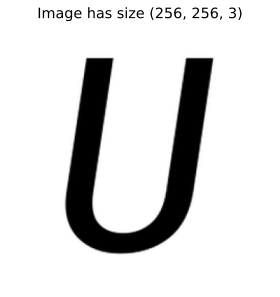

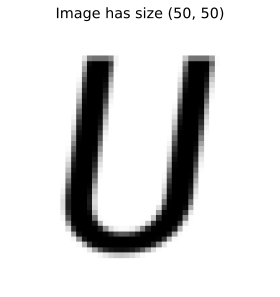

In [10]:
for batch in dummy_batch:
  original_image=batch[0][0]
  show_img(original_image)
  show_img(transforms_all(transforms.ToPILImage()(original_image)))
  break

### Separação em dados de treino e validação

**Etapas**

3. Separa parte dos dados em treinamento e validação.
    * São utilizadas apenas as primeiras 134 variações de fonte.
    * De cada variação, 42 imagens são copiadas para os dados de treino, e 20 imagens para os dados de validação.

In [11]:
folders=os.listdir(path)
count_folders_and_png_files(path, "Original Fonts")

shutil.rmtree(train_path)
shutil.rmtree(val_path)

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Podemos limitar em num_folders a quantidade total de pasta que iremos trabalhar, no total temos 1116.
num_folders = 134
count_folders = 1
for folder in folders:
    if count_folders <= num_folders:
      os.mkdir(f'{train_path}/{folder}')
      os.mkdir(f'{val_path}/{folder}')
      images = os.listdir(f'{path}/{folder}')
      random.shuffle(images)
      for image in images[:20]:
        shutil.copy(f'{path}/{folder}/{image}', f'{val_path}/{folder}/{image}')
      for image in images[20:]:
        shutil.copy(f'{path}/{folder}/{image}', f'{train_path}/{folder}/{image}')
    count_folders += 1

count_folders_and_png_files(train_path, "Train Fonts")
count_folders_and_png_files(val_path, "Val Fonts")

Original Fonts number of subfolders: 1,116
Original Fonts number of png files: 69,192
Train Fonts number of subfolders: 134
Train Fonts number of png files: 5,628
Val Fonts number of subfolders: 134
Val Fonts number of png files: 2,680


In [12]:
print(len(os.listdir(train_path)))
print(len(os.listdir(val_path)))

134
134


### Construção do Dataset e Dataloader

**Etapas**

4. Definição dos _DataLoaders_ de treinamento e validação.
    * Cada _DataLoader_ incorpora a redução de escala e transformação em imagens em escala de cinza.

In [13]:
def get_dataloaders(batch_size=64, size=50):
    transforms_set = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(size=size),
        transforms.ToTensor()
    ])

    train_loader=torch.utils.data.DataLoader(
        datasets.ImageFolder(f'{train_path}',transform=transforms_set),
        batch_size=batch_size, shuffle=True
    )

    val_loader=torch.utils.data.DataLoader(
        datasets.ImageFolder(f'{val_path}',transform=transforms_set),
        batch_size=batch_size, shuffle=True
    )

    return train_loader, val_loader

### Implementação VAE

**Etapas**

5. Definição da arquitetura do VAE
    * São utilizadas camadas densas.
    * Existem 3 elementos principais na arquitetura: **Encoder**, **Reparametrização** e **Decoder**.
    * **Encoder**:
        * Passa dados de entrada achatados (_flatten_) de dimensão 2500 para dimensão 1000. Seguido por ativação ReLU.
        * Passa dados da dimensão 1000 em duas camadas paralelas para a dimensão do espaço latente.
        * Cada dimensão do espaço latente é caracterizada por uma média ($\mu$) e um logarítimico da variância ($log(\sigma^2)$).
    * **Reparametrização**:
        * _Reamostra_ cada elemento do espaço latente em função das respectivas médias e logarítimicos da variância.

        $$
        \sigma = e^{0.5*log(\sigma^2)} \\
        x = \mu + \epsilon \sigma
        $$

        * A variável aleatória $\epsilon$ segue distribuição normal padrão: $\epsilon \sim \mathcal{N}(0, 1)$. 
    * **Decoder**:
        * Passa do espaço latente para a dimensão 1000, seguido de ativação ReLU.
        * Passa da dimensão 1000 de volta para a dimensão do dado original. A ativação sigmóide deixa os valores de saída dentro da faixa de variação do dado original: $[0,1]$.
    * Código original foi adaptado para dar mais flexibilidade de testar alterações na arquitetura.
        

In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim=50*50, z=32, hidden_dim=1000, n_hidden_encoder=1, n_hidden_decoder=1):
        super(VAE, self).__init__()

        assert n_hidden_encoder >= 1, 'Number of hidden layers must be at least 1.'
        assert n_hidden_decoder >= 1, 'Number of hidden layers must be at least 1.'

        self.input_dim = input_dim # Dimensão de entrada
        self.z = z # Dimensão do espaço latente
        self.hidden_dim = hidden_dim # Dimensão da camada escondida
        self.n_hidden_encoder = n_hidden_encoder # Número de camadas escondidas no encoder
        self.n_hidden_decoder = n_hidden_decoder # Número de camadas escondidas no decoder

        #ENCODER
        self.encoder = nn.Sequential()
         # Camada densa do dado de entrada para dimensão hidden_dim (1000)
        self.encoder.add_module('input_linear', nn.Linear(input_dim,hidden_dim))
        self.encoder.add_module('input_act',nn.ReLU())
        # Camadas densas ocultas adicionais
        for i in range(1, n_hidden_encoder):
            self.encoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.encoder.add_module(f'{i+1}_act',nn.ReLU())
        # Camadas densas de dimensão hidden_dim para espaço latente z: médias e log(vars)
        self.fc21 = nn.Linear(hidden_dim,z)
        self.fc22 = nn.Linear(hidden_dim,z)

        #DECODER
        self.decoder = nn.Sequential()
        # Camada densa do espaço latente z para dimensão hidden_dim
        self.decoder.add_module('input_linear', nn.Linear(z,hidden_dim))
        self.decoder.add_module('input_act',nn.ReLU())
        # Camadas densas ocultas adicionais
        for i in range(1, n_hidden_decoder):
            self.decoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.decoder.add_module(f'{i+1}_act',nn.ReLU())
        # Camadas densas de dimensão hidden_dim para dimensão de entrada
        self.decoder.add_module('output_linear', nn.Linear(hidden_dim,input_dim))
        self.decoder.add_module('output_act',nn.Sigmoid())

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # don't forget forward pass re-index
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Implementação Loss Function

**Etapas**

6. Definição da função de perda.
    * Existem dois termos na função de perda: **Entropia Binária Cruzada** e **Divergente de Kullback-Leibler**.
    * **Entropia Binária Cruzada**:
        * Medida do quando as imagens original e reconstruída se parecem, pixel a pixel.
    * **Divergente de Kullback-Leibler**:
        * Medida do quanto a distribuição do espaço latente se aproxima de uma distribuição normal padrão.
    * Desta forma a otimização dos pesos da rede tem duplo objetivo: reconstruir as imagens de entrada ao mesmo tempo que busca uma representação no espaço latente que siga uma normal padrão.
    * Código original foi alterado para retornar termos da _loss_ separadamente e incluir parâmetro para controlar impacto de cada termo.

In [15]:
def loss_function(recon_x, x, mu, logvar, beta=0.50, input_dim=50*50):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = 2.0 * ((1 - beta) * BCE + beta * KLD)
    return loss, BCE.detach(), KLD.detach()

### Criação do Modelo

**Etapas**

6. Cria nova instância do modelo.

In [16]:
def initialize_test_run(options):
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device: ',device)
    model=VAE(
        input_dim=options['input_dim_flat'],
        z=options['z'],
        hidden_dim=options['hidden_dim'],
        n_hidden_encoder=options['n_hidden_encoder'],
        n_hidden_decoder=options['n_hidden_decoder']).to(device)
    optimizer=optim.Adam(model.parameters(),lr=options['lr'])
    writer = SummaryWriter(f'_runs/{options["model_name"]}')
    return device, model, optimizer, writer

### Loops de Treinamento e Avaliação

**Etapas**

7. Rotina de avaliação:
    * Calcula a _loss_ média do conjunto de validação.
    * Guarda uma amostra comparando a figura original com a reconstruída.
8. Rotina para gerar novas amostras:
    * Guarda 64 amostras geradas a partir de amostragem no espaço latente.
9. Rotina de treino:
    * Treinamento realizado em mini-batches de 64 amostras e otimizador Adam.

In [17]:
def evaluate(epoch, device, model, writer, val_loader, options):

    val_loss = 0
    val_loss_bce = 0
    val_loss_kld = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader):

            data=data.to(device)
            recon_batch,mu,logvar=model(data)
            loss, loss_bce, loss_kld = loss_function(recon_batch,data,mu,logvar)
            val_loss += loss.item()
            val_loss_bce += loss_bce.item()
            val_loss_kld += loss_kld.item()

            if i == 0 and epoch%50==1:
                n = min(data.size(0), 16)
                comparison = torch.cat([
                    data[:n],
                    recon_batch.view(options['batch_size'], 1,
                                     options['input_dim'][0], options['input_dim'][1])[:n]]).cpu()
                grid = make_grid(comparison, nrow=16, normalize=True, scale_each=True).cpu()
                show_img(grid, title=f'Epoch {epoch}')
                writer.add_images('Img/Reconstruction', grid, epoch, dataformats='CHW')

    val_loss /= len(val_loader.dataset)
    val_loss_bce /= len(val_loader.dataset)
    val_loss_kld /= len(val_loader.dataset)
    return val_loss, val_loss_bce, val_loss_kld


def sample_latent_space(epoch, device, model, writer, options):
    with torch.no_grad():

        # how to sample from our latent space
        sample=torch.randn(64,32).to(device)
        sample=model.decode(sample).cpu()

        grid = make_grid(sample.view(64, 1, options['input_dim'][0], options['input_dim'][1]), nrow=8, normalize=False, scale_each=False)
        show_img(grid, title=f'Epoch {epoch}')
        writer.add_images('Img/Samples', grid, epoch, dataformats='CHW')

In [18]:
def train(device, model, optimizer, writer, train_loader, val_loader, epoch, options):
    model.train()

    train_loss = 0
    train_loss_bce = 0
    train_loss_kld = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch:03d}', leave=False, disable=False)
    for data, _ in progress_bar:
        progress_bar.set_description(f'Epoch {epoch:03d}')

        data=data.to(device)
        optimizer.zero_grad()
        recon_batch,mu,logvar=model(data)

        loss, loss_bce, loss_kld = loss_function(
            recon_batch,data,mu,logvar, beta=options['beta'], input_dim=options['input_dim_flat'])
        loss.backward()
        train_loss += loss.item()
        train_loss_bce += loss_bce.item()
        train_loss_kld += loss_kld.item()
        optimizer.step()

        progress_bar.set_postfix({'training_loss': f'{(loss.item() / len(data)):.3f}'})
    progress_bar.close()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_loss_bce = train_loss_bce / len(train_loader.dataset)
    avg_train_loss_kld = train_loss_kld / len(train_loader.dataset)
    val_loss, val_loss_bce, val_loss_kld = evaluate(
        epoch, device, model, writer, val_loader, options)

    print(f'Epoch {epoch:03d}: train={avg_train_loss:<8.3f} (BCE={avg_train_loss_bce:<8.3f}, KLD={avg_train_loss_kld:<8.3f}), val: {val_loss:<8.3f}')

    writer.add_scalar('Train_Loss/Total', avg_train_loss, epoch)
    writer.add_scalar('Train_Loss/BCE', avg_train_loss_bce, epoch)
    writer.add_scalar('Train_Loss/KLD', avg_train_loss_kld, epoch)

    writer.add_scalar('Val_Loss/Total', val_loss, epoch)
    writer.add_scalar('Val_Loss/BCE', val_loss_bce, epoch)
    writer.add_scalar('Val_Loss/KLD', val_loss_kld, epoch)

    if epoch%100==0:
        torch.save(model.state_dict(), f'./_models/{options["model_name"]}_{epoch}.model')

### Treinamento

**Etapas**

10. O processo de treinamento foi _empacotado_ em uma rotina para facilitar o teste de diferentes hiper-parâmetros.
    * Entre os poucos testes realizados, em inspeção visual constatou-se que é necessário aumentar o peso do divergente de KL no cálculo da função de perda.
    * Usando os hyper-parâmetros inciais a rede tinha boa capacidade de reconstrução das imagens, mas gerava novas imagens de baixa qualidade.

In [19]:
def make_run(options):
    print(options['model_name'])

    options['input_dim_flat'] = options['input_dim'][0] * options['input_dim'][1]
    device, model, optimizer, writer = initialize_test_run(options)
    train_loader, val_loader = get_dataloaders(options['batch_size'])

    writer.add_hparams({k:str(v) for k,v in options.items()}, {})

    epochs = options['epochs']
    for epoch in range(1,epochs+1):
        train(device, model, optimizer, writer, train_loader, val_loader, epoch, options)
        if epoch%50==1:
            sample_latent_space(epoch, device, model, writer, options)

    writer.flush()
    writer.close()

vae_20240927-171921
Device:  cuda


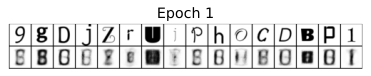

Epoch 001: train=676.816  (BCE=649.598 , KLD=27.218  ), val: 537.187 


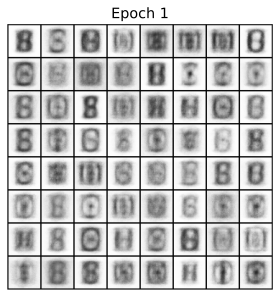

Epoch 002: train=492.535  (BCE=463.625 , KLD=28.910  ), val: 452.310 


Epoch 003: train=431.954  (BCE=397.517 , KLD=34.437  ), val: 411.958 


Epoch 004: train=397.038  (BCE=360.018 , KLD=37.021  ), val: 383.824 


Epoch 005: train=371.472  (BCE=332.365 , KLD=39.107  ), val: 362.393 


Epoch 006: train=356.153  (BCE=315.911 , KLD=40.242  ), val: 349.402 


Epoch 007: train=341.449  (BCE=300.025 , KLD=41.424  ), val: 341.720 


Epoch 008: train=330.404  (BCE=288.087 , KLD=42.317  ), val: 328.854 


Epoch 009: train=321.018  (BCE=277.813 , KLD=43.205  ), val: 323.023 


Epoch 010: train=312.534  (BCE=268.863 , KLD=43.671  ), val: 311.600 


Epoch 011: train=307.224  (BCE=262.863 , KLD=44.361  ), val: 313.586 


Epoch 012: train=302.299  (BCE=257.865 , KLD=44.434  ), val: 303.530 


Epoch 013: train=298.104  (BCE=253.599 , KLD=44.505  ), val: 301.050 


Epoch 014: train=293.462  (BCE=248.538 , KLD=44.924  ), val: 298.335 


Epoch 015: train=288.339  (BCE=243.420 , KLD=44.920  ), val: 296.803 


Epoch 016: train=286.718  (BCE=241.764 , KLD=44.954  ), val: 295.821 


Epoch 017: train=283.501  (BCE=238.394 , KLD=45.108  ), val: 292.196 


Epoch 018: train=279.889  (BCE=234.639 , KLD=45.250  ), val: 291.068 


Epoch 019: train=277.307  (BCE=232.074 , KLD=45.233  ), val: 288.073 


Epoch 020: train=275.314  (BCE=229.730 , KLD=45.584  ), val: 286.215 


Epoch 021: train=273.044  (BCE=227.584 , KLD=45.460  ), val: 284.552 


Epoch 022: train=272.126  (BCE=226.855 , KLD=45.271  ), val: 283.098 


Epoch 023: train=269.741  (BCE=224.263 , KLD=45.477  ), val: 281.646 


Epoch 024: train=266.286  (BCE=220.885 , KLD=45.401  ), val: 279.211 


Epoch 025: train=265.719  (BCE=220.034 , KLD=45.685  ), val: 281.360 


Epoch 026: train=264.142  (BCE=218.705 , KLD=45.438  ), val: 279.564 


Epoch 027: train=262.757  (BCE=217.249 , KLD=45.508  ), val: 279.932 


Epoch 028: train=261.390  (BCE=215.984 , KLD=45.406  ), val: 276.946 


Epoch 029: train=258.861  (BCE=213.333 , KLD=45.528  ), val: 274.085 


Epoch 030: train=258.567  (BCE=213.018 , KLD=45.548  ), val: 276.415 


Epoch 031: train=257.159  (BCE=211.590 , KLD=45.568  ), val: 272.397 


Epoch 032: train=255.351  (BCE=209.687 , KLD=45.664  ), val: 271.606 


Epoch 033: train=254.233  (BCE=208.773 , KLD=45.460  ), val: 271.886 


Epoch 034: train=254.748  (BCE=209.189 , KLD=45.559  ), val: 272.513 


Epoch 035: train=253.965  (BCE=208.490 , KLD=45.475  ), val: 269.393 


Epoch 036: train=251.223  (BCE=205.852 , KLD=45.370  ), val: 271.051 


Epoch 037: train=250.490  (BCE=205.045 , KLD=45.445  ), val: 267.956 


Epoch 038: train=249.574  (BCE=203.979 , KLD=45.595  ), val: 269.018 


Epoch 039: train=247.961  (BCE=202.518 , KLD=45.443  ), val: 268.565 


Epoch 040: train=248.018  (BCE=202.542 , KLD=45.476  ), val: 268.833 


Epoch 041: train=247.126  (BCE=201.708 , KLD=45.418  ), val: 270.050 


Epoch 042: train=246.081  (BCE=200.467 , KLD=45.614  ), val: 268.495 


Epoch 043: train=246.069  (BCE=200.681 , KLD=45.388  ), val: 267.749 


Epoch 044: train=244.924  (BCE=199.281 , KLD=45.644  ), val: 263.787 


Epoch 045: train=243.099  (BCE=197.681 , KLD=45.419  ), val: 266.231 


Epoch 046: train=243.224  (BCE=197.697 , KLD=45.527  ), val: 265.379 


Epoch 047: train=243.070  (BCE=197.418 , KLD=45.652  ), val: 264.855 


Epoch 048: train=242.393  (BCE=196.877 , KLD=45.516  ), val: 265.977 


Epoch 049: train=241.413  (BCE=195.791 , KLD=45.621  ), val: 263.857 


Epoch 050: train=241.597  (BCE=196.161 , KLD=45.436  ), val: 262.875 


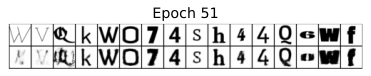

Epoch 051: train=239.917  (BCE=194.539 , KLD=45.378  ), val: 265.206 


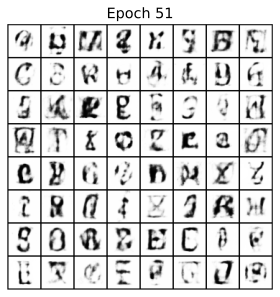

Epoch 052: train=241.257  (BCE=195.725 , KLD=45.532  ), val: 264.579 


Epoch 053: train=238.818  (BCE=193.323 , KLD=45.496  ), val: 263.765 


Epoch 054: train=239.359  (BCE=193.891 , KLD=45.468  ), val: 264.643 


Epoch 055: train=238.436  (BCE=192.852 , KLD=45.585  ), val: 263.445 


Epoch 056: train=238.000  (BCE=192.444 , KLD=45.556  ), val: 265.051 


Epoch 057: train=236.796  (BCE=191.480 , KLD=45.315  ), val: 262.503 


Epoch 058: train=237.067  (BCE=191.596 , KLD=45.471  ), val: 263.101 


Epoch 059: train=237.230  (BCE=191.579 , KLD=45.651  ), val: 263.960 


Epoch 060: train=236.018  (BCE=190.408 , KLD=45.609  ), val: 262.009 


Epoch 061: train=236.031  (BCE=190.428 , KLD=45.603  ), val: 262.957 


Epoch 062: train=235.209  (BCE=189.574 , KLD=45.635  ), val: 262.412 


Epoch 063: train=235.204  (BCE=189.650 , KLD=45.554  ), val: 265.121 


Epoch 064: train=234.877  (BCE=189.532 , KLD=45.345  ), val: 263.985 


Epoch 065: train=234.461  (BCE=188.873 , KLD=45.588  ), val: 262.852 


Epoch 066: train=232.896  (BCE=187.327 , KLD=45.569  ), val: 262.406 


Epoch 067: train=233.459  (BCE=187.874 , KLD=45.585  ), val: 264.497 


Epoch 068: train=234.586  (BCE=188.943 , KLD=45.643  ), val: 263.985 


Epoch 069: train=233.405  (BCE=187.826 , KLD=45.580  ), val: 260.780 


Epoch 070: train=232.514  (BCE=186.890 , KLD=45.624  ), val: 264.579 


Epoch 071: train=232.232  (BCE=186.620 , KLD=45.612  ), val: 259.152 


Epoch 072: train=231.948  (BCE=186.443 , KLD=45.504  ), val: 263.744 


Epoch 073: train=231.751  (BCE=186.186 , KLD=45.565  ), val: 261.669 


Epoch 074: train=230.781  (BCE=185.060 , KLD=45.721  ), val: 261.324 


Epoch 075: train=230.695  (BCE=185.059 , KLD=45.636  ), val: 263.829 


Epoch 076: train=231.926  (BCE=186.311 , KLD=45.615  ), val: 260.762 


Epoch 077: train=230.636  (BCE=185.105 , KLD=45.531  ), val: 262.546 


Epoch 078: train=229.616  (BCE=184.094 , KLD=45.522  ), val: 260.884 


Epoch 079: train=230.193  (BCE=184.430 , KLD=45.763  ), val: 261.938 


Epoch 080: train=229.489  (BCE=183.723 , KLD=45.766  ), val: 261.423 


Epoch 081: train=229.323  (BCE=183.687 , KLD=45.636  ), val: 264.473 


Epoch 082: train=230.420  (BCE=184.893 , KLD=45.527  ), val: 262.923 


Epoch 083: train=230.266  (BCE=184.518 , KLD=45.748  ), val: 261.666 


Epoch 084: train=228.471  (BCE=182.707 , KLD=45.763  ), val: 260.808 


Epoch 085: train=228.579  (BCE=182.883 , KLD=45.696  ), val: 261.772 


Epoch 086: train=228.359  (BCE=182.681 , KLD=45.678  ), val: 262.103 


Epoch 087: train=228.392  (BCE=182.708 , KLD=45.684  ), val: 260.633 


Epoch 088: train=227.190  (BCE=181.520 , KLD=45.671  ), val: 259.739 


Epoch 089: train=227.629  (BCE=182.061 , KLD=45.568  ), val: 261.262 


Epoch 090: train=227.067  (BCE=181.373 , KLD=45.694  ), val: 262.708 


Epoch 091: train=227.827  (BCE=182.078 , KLD=45.749  ), val: 261.187 


Epoch 092: train=227.077  (BCE=181.337 , KLD=45.740  ), val: 260.668 


Epoch 093: train=225.915  (BCE=180.279 , KLD=45.635  ), val: 259.681 


Epoch 094: train=226.092  (BCE=180.413 , KLD=45.679  ), val: 262.948 


Epoch 095: train=226.479  (BCE=180.800 , KLD=45.678  ), val: 260.054 


Epoch 096: train=226.349  (BCE=180.556 , KLD=45.793  ), val: 263.691 


Epoch 097: train=226.807  (BCE=180.973 , KLD=45.833  ), val: 260.701 


Epoch 098: train=225.626  (BCE=179.845 , KLD=45.782  ), val: 259.894 


Epoch 099: train=225.329  (BCE=179.806 , KLD=45.523  ), val: 262.072 


Epoch 100: train=226.381  (BCE=180.553 , KLD=45.828  ), val: 262.179 


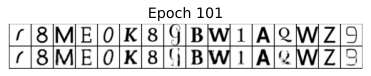

Epoch 101: train=225.964  (BCE=180.224 , KLD=45.740  ), val: 263.714 


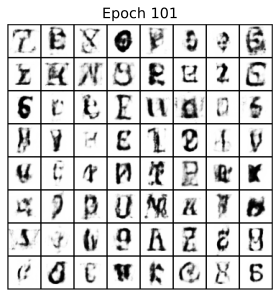

Epoch 102: train=225.187  (BCE=179.437 , KLD=45.749  ), val: 262.054 


Epoch 103: train=225.628  (BCE=179.871 , KLD=45.757  ), val: 262.529 


Epoch 104: train=225.915  (BCE=180.104 , KLD=45.811  ), val: 260.229 


Epoch 105: train=224.746  (BCE=178.970 , KLD=45.776  ), val: 261.100 


Epoch 106: train=225.226  (BCE=179.495 , KLD=45.731  ), val: 264.536 


Epoch 107: train=224.549  (BCE=178.802 , KLD=45.747  ), val: 260.284 


Epoch 108: train=224.324  (BCE=178.643 , KLD=45.681  ), val: 261.634 


Epoch 109: train=224.299  (BCE=178.578 , KLD=45.721  ), val: 263.559 


Epoch 110: train=224.250  (BCE=178.547 , KLD=45.703  ), val: 261.306 


Epoch 111: train=223.988  (BCE=178.236 , KLD=45.752  ), val: 262.861 


Epoch 112: train=223.305  (BCE=177.447 , KLD=45.858  ), val: 260.090 


Epoch 113: train=223.243  (BCE=177.550 , KLD=45.693  ), val: 262.891 


Epoch 114: train=223.169  (BCE=177.446 , KLD=45.722  ), val: 261.268 


Epoch 115: train=223.273  (BCE=177.484 , KLD=45.789  ), val: 261.905 


Epoch 116: train=222.626  (BCE=176.913 , KLD=45.712  ), val: 262.775 


Epoch 117: train=222.633  (BCE=176.799 , KLD=45.834  ), val: 260.550 


Epoch 118: train=222.123  (BCE=176.277 , KLD=45.846  ), val: 263.215 


Epoch 119: train=223.418  (BCE=177.603 , KLD=45.815  ), val: 261.617 


Epoch 120: train=223.538  (BCE=177.560 , KLD=45.978  ), val: 261.015 


Epoch 121: train=222.355  (BCE=176.597 , KLD=45.758  ), val: 261.847 


Epoch 122: train=222.597  (BCE=176.814 , KLD=45.783  ), val: 261.688 


Epoch 123: train=222.073  (BCE=176.477 , KLD=45.596  ), val: 259.985 


Epoch 124: train=221.269  (BCE=175.622 , KLD=45.647  ), val: 263.052 


Epoch 125: train=221.918  (BCE=176.144 , KLD=45.774  ), val: 262.901 


Epoch 126: train=222.211  (BCE=176.291 , KLD=45.920  ), val: 261.403 


Epoch 127: train=220.960  (BCE=175.247 , KLD=45.713  ), val: 264.101 


Epoch 128: train=221.502  (BCE=175.699 , KLD=45.803  ), val: 262.976 


Epoch 129: train=220.978  (BCE=175.242 , KLD=45.736  ), val: 261.519 


Epoch 130: train=220.770  (BCE=175.101 , KLD=45.669  ), val: 264.073 


Epoch 131: train=221.029  (BCE=175.255 , KLD=45.774  ), val: 261.514 


Epoch 132: train=221.350  (BCE=175.526 , KLD=45.824  ), val: 260.839 


Epoch 133: train=220.734  (BCE=174.923 , KLD=45.811  ), val: 262.464 


Epoch 134: train=221.278  (BCE=175.488 , KLD=45.790  ), val: 263.637 


Epoch 135: train=221.616  (BCE=175.715 , KLD=45.901  ), val: 263.030 


Epoch 136: train=221.101  (BCE=175.147 , KLD=45.954  ), val: 261.417 


Epoch 137: train=219.178  (BCE=173.357 , KLD=45.821  ), val: 260.463 


Epoch 138: train=219.928  (BCE=174.113 , KLD=45.816  ), val: 260.859 


Epoch 139: train=220.196  (BCE=174.444 , KLD=45.751  ), val: 266.555 


Epoch 140: train=220.252  (BCE=174.329 , KLD=45.923  ), val: 259.940 


Epoch 141: train=219.141  (BCE=173.357 , KLD=45.783  ), val: 261.146 


Epoch 142: train=219.686  (BCE=173.804 , KLD=45.882  ), val: 264.026 


Epoch 143: train=219.688  (BCE=173.805 , KLD=45.883  ), val: 261.492 


Epoch 144: train=219.629  (BCE=173.750 , KLD=45.878  ), val: 261.521 


Epoch 145: train=219.499  (BCE=173.589 , KLD=45.910  ), val: 263.300 


Epoch 146: train=219.831  (BCE=174.007 , KLD=45.824  ), val: 262.243 


Epoch 147: train=219.564  (BCE=173.756 , KLD=45.807  ), val: 261.241 


Epoch 148: train=219.011  (BCE=173.183 , KLD=45.828  ), val: 262.219 


Epoch 149: train=219.320  (BCE=173.498 , KLD=45.822  ), val: 264.309 


Epoch 150: train=218.428  (BCE=172.578 , KLD=45.850  ), val: 262.779 


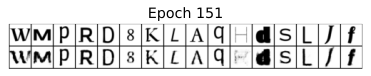

Epoch 151: train=218.494  (BCE=172.634 , KLD=45.860  ), val: 261.783 


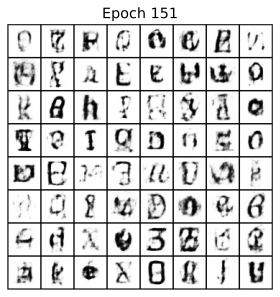

Epoch 152: train=217.471  (BCE=171.809 , KLD=45.662  ), val: 263.597 


Epoch 153: train=218.964  (BCE=173.079 , KLD=45.885  ), val: 262.484 


Epoch 154: train=218.537  (BCE=172.870 , KLD=45.667  ), val: 261.675 


Epoch 155: train=218.532  (BCE=172.594 , KLD=45.938  ), val: 262.742 


Epoch 156: train=219.658  (BCE=173.876 , KLD=45.781  ), val: 264.326 


Epoch 157: train=218.805  (BCE=172.831 , KLD=45.974  ), val: 264.288 


Epoch 158: train=218.809  (BCE=173.040 , KLD=45.769  ), val: 265.316 


Epoch 159: train=218.977  (BCE=173.114 , KLD=45.863  ), val: 264.311 


Epoch 160: train=217.875  (BCE=171.887 , KLD=45.987  ), val: 263.494 


Epoch 161: train=217.959  (BCE=172.047 , KLD=45.911  ), val: 262.409 


Epoch 162: train=218.390  (BCE=172.648 , KLD=45.742  ), val: 261.745 


Epoch 163: train=218.031  (BCE=172.223 , KLD=45.808  ), val: 262.253 


Epoch 164: train=217.275  (BCE=171.493 , KLD=45.781  ), val: 261.799 


Epoch 165: train=216.715  (BCE=170.809 , KLD=45.905  ), val: 263.385 


Epoch 166: train=217.472  (BCE=171.675 , KLD=45.796  ), val: 262.789 


Epoch 167: train=216.954  (BCE=171.145 , KLD=45.809  ), val: 261.952 


Epoch 168: train=216.241  (BCE=170.484 , KLD=45.757  ), val: 261.119 


Epoch 169: train=217.184  (BCE=171.286 , KLD=45.898  ), val: 262.505 


Epoch 170: train=217.621  (BCE=171.776 , KLD=45.845  ), val: 262.997 


Epoch 171: train=217.437  (BCE=171.485 , KLD=45.952  ), val: 265.730 


Epoch 172: train=217.413  (BCE=171.523 , KLD=45.890  ), val: 261.324 


Epoch 173: train=216.682  (BCE=170.794 , KLD=45.888  ), val: 263.739 


Epoch 174: train=217.116  (BCE=171.166 , KLD=45.951  ), val: 264.896 


Epoch 175: train=217.461  (BCE=171.532 , KLD=45.929  ), val: 262.995 


Epoch 176: train=217.898  (BCE=172.043 , KLD=45.854  ), val: 263.128 


Epoch 177: train=216.417  (BCE=170.547 , KLD=45.870  ), val: 261.962 


Epoch 178: train=217.003  (BCE=171.103 , KLD=45.900  ), val: 264.359 


Epoch 179: train=216.002  (BCE=170.230 , KLD=45.771  ), val: 261.544 


Epoch 180: train=216.344  (BCE=170.561 , KLD=45.783  ), val: 262.176 


Epoch 181: train=215.548  (BCE=169.719 , KLD=45.829  ), val: 263.360 


Epoch 182: train=216.548  (BCE=170.726 , KLD=45.822  ), val: 262.051 


Epoch 183: train=216.170  (BCE=170.349 , KLD=45.821  ), val: 264.625 


Epoch 184: train=216.542  (BCE=170.723 , KLD=45.819  ), val: 261.896 


Epoch 185: train=215.678  (BCE=169.850 , KLD=45.828  ), val: 261.784 


Epoch 186: train=216.476  (BCE=170.523 , KLD=45.953  ), val: 262.037 


Epoch 187: train=216.086  (BCE=170.173 , KLD=45.913  ), val: 263.457 


Epoch 188: train=215.481  (BCE=169.712 , KLD=45.770  ), val: 261.115 


Epoch 189: train=215.891  (BCE=170.064 , KLD=45.827  ), val: 266.888 


Epoch 190: train=216.343  (BCE=170.452 , KLD=45.891  ), val: 265.447 


Epoch 191: train=216.112  (BCE=170.192 , KLD=45.920  ), val: 263.866 


Epoch 192: train=215.903  (BCE=170.044 , KLD=45.859  ), val: 263.966 


Epoch 193: train=215.330  (BCE=169.504 , KLD=45.826  ), val: 265.861 


Epoch 194: train=216.055  (BCE=170.066 , KLD=45.989  ), val: 264.055 


Epoch 195: train=215.345  (BCE=169.487 , KLD=45.859  ), val: 264.946 


Epoch 196: train=215.263  (BCE=169.407 , KLD=45.857  ), val: 264.457 


Epoch 197: train=215.103  (BCE=169.292 , KLD=45.810  ), val: 262.086 


Epoch 198: train=214.519  (BCE=168.532 , KLD=45.987  ), val: 265.275 


Epoch 199: train=216.539  (BCE=170.764 , KLD=45.775  ), val: 264.640 


Epoch 200: train=216.055  (BCE=170.134 , KLD=45.921  ), val: 263.865 


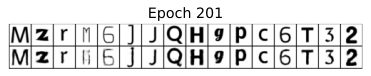

Epoch 201: train=215.143  (BCE=169.141 , KLD=46.002  ), val: 265.857 


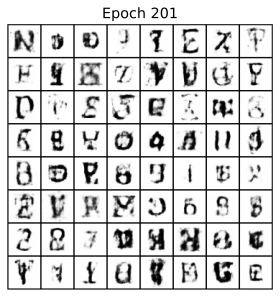

Epoch 202: train=214.712  (BCE=168.940 , KLD=45.772  ), val: 264.577 


Epoch 203: train=215.400  (BCE=169.485 , KLD=45.915  ), val: 266.496 


Epoch 204: train=215.433  (BCE=169.348 , KLD=46.085  ), val: 266.446 


Epoch 205: train=214.619  (BCE=168.634 , KLD=45.985  ), val: 264.171 


Epoch 206: train=215.229  (BCE=169.406 , KLD=45.823  ), val: 262.903 


Epoch 207: train=213.968  (BCE=168.085 , KLD=45.883  ), val: 264.985 


Epoch 208: train=214.410  (BCE=168.547 , KLD=45.862  ), val: 264.188 


Epoch 209: train=214.539  (BCE=168.696 , KLD=45.843  ), val: 263.845 


Epoch 210: train=215.131  (BCE=169.262 , KLD=45.869  ), val: 262.048 


Epoch 211: train=214.527  (BCE=168.635 , KLD=45.892  ), val: 264.742 


Epoch 212: train=214.197  (BCE=168.396 , KLD=45.801  ), val: 265.452 


Epoch 213: train=214.310  (BCE=168.511 , KLD=45.799  ), val: 265.261 


Epoch 214: train=214.298  (BCE=168.302 , KLD=45.996  ), val: 263.028 


Epoch 215: train=213.631  (BCE=167.753 , KLD=45.878  ), val: 264.889 


Epoch 216: train=213.937  (BCE=168.079 , KLD=45.859  ), val: 265.342 


Epoch 217: train=214.236  (BCE=168.336 , KLD=45.901  ), val: 266.193 


Epoch 218: train=214.702  (BCE=168.886 , KLD=45.815  ), val: 265.243 


Epoch 219: train=215.142  (BCE=169.277 , KLD=45.865  ), val: 268.618 


Epoch 220: train=213.000  (BCE=167.213 , KLD=45.787  ), val: 262.571 


Epoch 221: train=213.925  (BCE=168.068 , KLD=45.857  ), val: 263.979 


Epoch 222: train=213.808  (BCE=167.856 , KLD=45.952  ), val: 264.942 


Epoch 223: train=213.397  (BCE=167.571 , KLD=45.826  ), val: 265.049 


Epoch 224: train=213.627  (BCE=167.802 , KLD=45.825  ), val: 263.879 


Epoch 225: train=214.171  (BCE=168.246 , KLD=45.925  ), val: 261.947 


Epoch 226: train=214.035  (BCE=168.115 , KLD=45.920  ), val: 268.705 


Epoch 227: train=213.403  (BCE=167.609 , KLD=45.794  ), val: 267.395 


Epoch 228: train=213.221  (BCE=167.460 , KLD=45.761  ), val: 266.806 


Epoch 229: train=213.600  (BCE=167.760 , KLD=45.839  ), val: 265.598 


Epoch 230: train=213.469  (BCE=167.684 , KLD=45.786  ), val: 263.033 


Epoch 231: train=212.970  (BCE=167.122 , KLD=45.848  ), val: 265.267 


Epoch 232: train=212.755  (BCE=166.852 , KLD=45.903  ), val: 264.336 


Epoch 233: train=213.104  (BCE=167.151 , KLD=45.952  ), val: 264.753 


Epoch 234: train=213.155  (BCE=167.351 , KLD=45.804  ), val: 265.871 


Epoch 235: train=213.865  (BCE=167.819 , KLD=46.047  ), val: 264.764 


Epoch 236: train=213.791  (BCE=167.793 , KLD=45.998  ), val: 263.260 


Epoch 237: train=213.181  (BCE=167.244 , KLD=45.937  ), val: 263.991 


Epoch 238: train=213.217  (BCE=167.354 , KLD=45.863  ), val: 262.735 


Epoch 239: train=213.285  (BCE=167.439 , KLD=45.846  ), val: 264.334 


Epoch 240: train=212.620  (BCE=166.789 , KLD=45.831  ), val: 264.514 


Epoch 241: train=213.195  (BCE=167.321 , KLD=45.874  ), val: 267.938 


Epoch 242: train=213.491  (BCE=167.564 , KLD=45.927  ), val: 264.028 


Epoch 243: train=212.459  (BCE=166.651 , KLD=45.808  ), val: 267.566 


Epoch 244: train=212.563  (BCE=166.637 , KLD=45.927  ), val: 264.549 


Epoch 245: train=213.234  (BCE=167.310 , KLD=45.924  ), val: 264.402 


Epoch 246: train=212.723  (BCE=166.732 , KLD=45.991  ), val: 266.266 


Epoch 247: train=212.873  (BCE=166.970 , KLD=45.903  ), val: 262.449 


Epoch 248: train=212.872  (BCE=166.962 , KLD=45.910  ), val: 266.278 


Epoch 249: train=212.590  (BCE=166.691 , KLD=45.899  ), val: 265.633 


Epoch 250: train=212.895  (BCE=166.976 , KLD=45.919  ), val: 263.452 


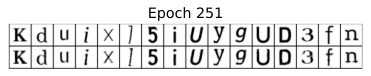

Epoch 251: train=212.886  (BCE=167.011 , KLD=45.875  ), val: 265.989 


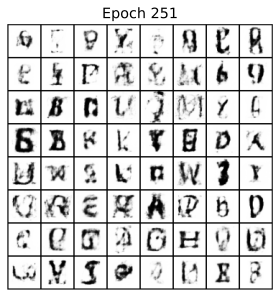

Epoch 252: train=212.242  (BCE=166.448 , KLD=45.794  ), val: 265.060 


Epoch 253: train=212.064  (BCE=166.216 , KLD=45.848  ), val: 264.609 


Epoch 254: train=212.285  (BCE=166.465 , KLD=45.820  ), val: 265.859 


Epoch 255: train=212.169  (BCE=166.197 , KLD=45.972  ), val: 264.974 


Epoch 256: train=212.729  (BCE=166.819 , KLD=45.911  ), val: 265.205 


Epoch 257: train=212.257  (BCE=166.317 , KLD=45.941  ), val: 268.158 


Epoch 258: train=212.895  (BCE=166.859 , KLD=46.036  ), val: 265.444 


Epoch 259: train=212.972  (BCE=166.903 , KLD=46.069  ), val: 265.075 


Epoch 260: train=211.905  (BCE=165.977 , KLD=45.928  ), val: 265.059 


Epoch 261: train=211.739  (BCE=165.867 , KLD=45.872  ), val: 267.193 


Epoch 262: train=212.368  (BCE=166.389 , KLD=45.979  ), val: 267.440 


Epoch 263: train=212.209  (BCE=166.240 , KLD=45.969  ), val: 265.329 


Epoch 264: train=212.404  (BCE=166.369 , KLD=46.035  ), val: 264.339 


Epoch 265: train=211.139  (BCE=165.363 , KLD=45.776  ), val: 267.623 


Epoch 266: train=211.500  (BCE=165.693 , KLD=45.807  ), val: 267.288 


Epoch 267: train=211.355  (BCE=165.402 , KLD=45.953  ), val: 265.923 


Epoch 268: train=212.002  (BCE=166.225 , KLD=45.777  ), val: 265.723 


Epoch 269: train=211.603  (BCE=165.644 , KLD=45.959  ), val: 266.335 


Epoch 270: train=212.091  (BCE=166.146 , KLD=45.945  ), val: 267.460 


Epoch 271: train=212.115  (BCE=166.278 , KLD=45.837  ), val: 266.286 


Epoch 272: train=212.089  (BCE=166.254 , KLD=45.835  ), val: 265.298 


Epoch 273: train=211.047  (BCE=165.298 , KLD=45.749  ), val: 265.538 


Epoch 274: train=211.803  (BCE=165.856 , KLD=45.948  ), val: 267.708 


Epoch 275: train=211.681  (BCE=165.899 , KLD=45.782  ), val: 264.853 


Epoch 276: train=211.544  (BCE=165.715 , KLD=45.829  ), val: 266.994 


Epoch 277: train=212.296  (BCE=166.279 , KLD=46.017  ), val: 266.620 


Epoch 278: train=211.154  (BCE=165.308 , KLD=45.846  ), val: 265.836 


Epoch 279: train=210.585  (BCE=164.793 , KLD=45.792  ), val: 268.395 


Epoch 280: train=212.018  (BCE=166.186 , KLD=45.832  ), val: 269.383 


Epoch 281: train=211.990  (BCE=165.986 , KLD=46.004  ), val: 267.154 


Epoch 282: train=211.043  (BCE=165.329 , KLD=45.715  ), val: 266.833 


Epoch 283: train=211.800  (BCE=165.886 , KLD=45.914  ), val: 266.644 


Epoch 284: train=212.503  (BCE=166.483 , KLD=46.020  ), val: 268.892 


Epoch 285: train=211.016  (BCE=165.092 , KLD=45.924  ), val: 265.255 


Epoch 286: train=211.052  (BCE=165.306 , KLD=45.746  ), val: 267.692 


Epoch 287: train=210.654  (BCE=164.874 , KLD=45.780  ), val: 267.369 


Epoch 288: train=211.388  (BCE=165.566 , KLD=45.822  ), val: 265.785 


Epoch 289: train=210.739  (BCE=165.049 , KLD=45.690  ), val: 266.994 


Epoch 290: train=211.033  (BCE=165.171 , KLD=45.862  ), val: 267.541 


Epoch 291: train=210.911  (BCE=164.940 , KLD=45.971  ), val: 269.105 


Epoch 292: train=211.282  (BCE=165.465 , KLD=45.817  ), val: 270.533 


Epoch 293: train=211.576  (BCE=165.513 , KLD=46.062  ), val: 267.522 


Epoch 294: train=210.871  (BCE=165.142 , KLD=45.728  ), val: 269.633 


Epoch 295: train=211.260  (BCE=165.422 , KLD=45.838  ), val: 269.332 


Epoch 296: train=211.389  (BCE=165.483 , KLD=45.906  ), val: 265.810 


Epoch 297: train=210.538  (BCE=164.576 , KLD=45.962  ), val: 266.980 


Epoch 298: train=211.283  (BCE=165.544 , KLD=45.739  ), val: 266.084 


Epoch 299: train=209.986  (BCE=164.190 , KLD=45.796  ), val: 267.998 


Epoch 300: train=210.533  (BCE=164.660 , KLD=45.873  ), val: 267.417 


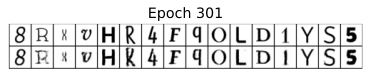

Epoch 301: train=210.957  (BCE=165.034 , KLD=45.923  ), val: 267.876 


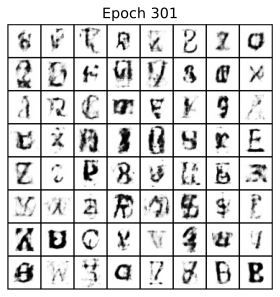

Epoch 302: train=211.429  (BCE=165.513 , KLD=45.916  ), val: 267.001 


Epoch 303: train=210.886  (BCE=164.939 , KLD=45.947  ), val: 266.781 


Epoch 304: train=210.689  (BCE=164.789 , KLD=45.901  ), val: 266.251 


Epoch 305: train=210.389  (BCE=164.495 , KLD=45.893  ), val: 265.281 


Epoch 306: train=210.832  (BCE=165.069 , KLD=45.764  ), val: 267.605 


Epoch 307: train=211.139  (BCE=165.275 , KLD=45.864  ), val: 266.960 


Epoch 308: train=211.586  (BCE=165.650 , KLD=45.936  ), val: 268.776 


Epoch 309: train=210.260  (BCE=164.535 , KLD=45.725  ), val: 266.695 


Epoch 310: train=210.542  (BCE=164.664 , KLD=45.879  ), val: 265.575 


Epoch 311: train=210.276  (BCE=164.400 , KLD=45.876  ), val: 266.476 


Epoch 312: train=210.401  (BCE=164.631 , KLD=45.769  ), val: 270.552 


Epoch 313: train=211.053  (BCE=165.216 , KLD=45.837  ), val: 268.437 


Epoch 314: train=210.400  (BCE=164.660 , KLD=45.739  ), val: 267.902 


Epoch 315: train=210.694  (BCE=164.724 , KLD=45.970  ), val: 269.257 


Epoch 316: train=210.328  (BCE=164.415 , KLD=45.913  ), val: 267.835 


Epoch 317: train=210.174  (BCE=164.300 , KLD=45.874  ), val: 268.381 


Epoch 318: train=210.046  (BCE=164.135 , KLD=45.911  ), val: 266.006 


Epoch 319: train=209.868  (BCE=164.099 , KLD=45.769  ), val: 267.343 


Epoch 320: train=210.047  (BCE=164.207 , KLD=45.840  ), val: 267.403 


Epoch 321: train=210.472  (BCE=164.635 , KLD=45.838  ), val: 267.532 


Epoch 322: train=209.387  (BCE=163.420 , KLD=45.967  ), val: 268.927 


Epoch 323: train=209.971  (BCE=164.097 , KLD=45.874  ), val: 268.659 


Epoch 324: train=209.904  (BCE=164.036 , KLD=45.868  ), val: 266.384 


Epoch 325: train=210.488  (BCE=164.679 , KLD=45.810  ), val: 269.256 


Epoch 326: train=209.831  (BCE=164.115 , KLD=45.716  ), val: 265.965 


Epoch 327: train=209.376  (BCE=163.451 , KLD=45.925  ), val: 269.642 


Epoch 328: train=209.696  (BCE=163.703 , KLD=45.993  ), val: 267.580 


Epoch 329: train=209.879  (BCE=164.021 , KLD=45.857  ), val: 266.669 


Epoch 330: train=209.933  (BCE=164.018 , KLD=45.915  ), val: 271.611 


Epoch 331: train=210.138  (BCE=164.261 , KLD=45.877  ), val: 267.705 


Epoch 332: train=209.972  (BCE=164.079 , KLD=45.893  ), val: 270.106 


Epoch 333: train=210.189  (BCE=164.372 , KLD=45.817  ), val: 268.374 


Epoch 334: train=210.789  (BCE=165.026 , KLD=45.763  ), val: 267.758 


Epoch 335: train=209.452  (BCE=163.612 , KLD=45.840  ), val: 266.944 


Epoch 336: train=210.434  (BCE=164.527 , KLD=45.907  ), val: 270.318 


Epoch 337: train=209.517  (BCE=163.709 , KLD=45.808  ), val: 270.787 


Epoch 338: train=209.774  (BCE=163.963 , KLD=45.811  ), val: 269.361 


Epoch 339: train=209.762  (BCE=163.835 , KLD=45.927  ), val: 270.701 


Epoch 340: train=209.980  (BCE=164.129 , KLD=45.851  ), val: 267.956 


Epoch 341: train=209.285  (BCE=163.533 , KLD=45.752  ), val: 267.895 


Epoch 342: train=210.028  (BCE=164.145 , KLD=45.883  ), val: 267.393 


Epoch 343: train=209.954  (BCE=164.110 , KLD=45.844  ), val: 266.517 


Epoch 344: train=210.228  (BCE=164.243 , KLD=45.986  ), val: 268.680 


Epoch 345: train=209.207  (BCE=163.427 , KLD=45.780  ), val: 269.358 


Epoch 346: train=209.093  (BCE=163.185 , KLD=45.908  ), val: 267.678 


Epoch 347: train=209.714  (BCE=163.903 , KLD=45.811  ), val: 267.279 


Epoch 348: train=209.975  (BCE=164.275 , KLD=45.699  ), val: 268.805 


Epoch 349: train=209.512  (BCE=163.653 , KLD=45.859  ), val: 268.370 


Epoch 350: train=209.291  (BCE=163.436 , KLD=45.855  ), val: 266.839 


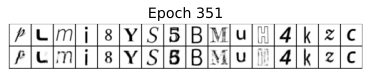

Epoch 351: train=210.048  (BCE=164.215 , KLD=45.833  ), val: 268.824 


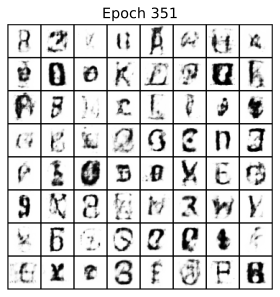

Epoch 352: train=208.576  (BCE=162.808 , KLD=45.768  ), val: 268.125 


Epoch 353: train=209.104  (BCE=163.342 , KLD=45.762  ), val: 270.157 


Epoch 354: train=209.795  (BCE=163.957 , KLD=45.838  ), val: 269.135 


Epoch 355: train=209.943  (BCE=164.117 , KLD=45.825  ), val: 268.382 


Epoch 356: train=209.284  (BCE=163.398 , KLD=45.886  ), val: 267.695 


Epoch 357: train=209.031  (BCE=163.079 , KLD=45.952  ), val: 268.328 


Epoch 358: train=208.823  (BCE=162.975 , KLD=45.848  ), val: 267.924 


Epoch 359: train=208.746  (BCE=163.034 , KLD=45.712  ), val: 269.548 


Epoch 360: train=209.495  (BCE=163.805 , KLD=45.690  ), val: 268.841 


Epoch 361: train=209.373  (BCE=163.580 , KLD=45.793  ), val: 266.674 


Epoch 362: train=208.818  (BCE=162.985 , KLD=45.833  ), val: 268.554 


Epoch 363: train=209.351  (BCE=163.461 , KLD=45.891  ), val: 270.218 


Epoch 364: train=209.257  (BCE=163.534 , KLD=45.723  ), val: 268.021 


Epoch 365: train=209.278  (BCE=163.353 , KLD=45.925  ), val: 267.249 


Epoch 366: train=209.392  (BCE=163.498 , KLD=45.894  ), val: 268.983 


Epoch 367: train=209.677  (BCE=163.946 , KLD=45.731  ), val: 267.954 


Epoch 368: train=209.128  (BCE=163.318 , KLD=45.811  ), val: 270.562 


Epoch 369: train=209.715  (BCE=163.928 , KLD=45.788  ), val: 269.199 


Epoch 370: train=209.720  (BCE=163.829 , KLD=45.891  ), val: 270.220 


Epoch 371: train=209.037  (BCE=163.233 , KLD=45.804  ), val: 269.233 


Epoch 372: train=209.764  (BCE=164.028 , KLD=45.736  ), val: 266.327 


Epoch 373: train=209.107  (BCE=163.246 , KLD=45.860  ), val: 272.202 


Epoch 374: train=208.898  (BCE=163.118 , KLD=45.780  ), val: 269.432 


Epoch 375: train=208.883  (BCE=163.103 , KLD=45.780  ), val: 270.325 


Epoch 376: train=209.544  (BCE=163.577 , KLD=45.968  ), val: 269.549 


Epoch 377: train=209.292  (BCE=163.382 , KLD=45.909  ), val: 269.146 


Epoch 378: train=208.540  (BCE=162.840 , KLD=45.700  ), val: 272.422 


Epoch 379: train=208.618  (BCE=162.839 , KLD=45.779  ), val: 267.204 


Epoch 380: train=208.217  (BCE=162.441 , KLD=45.776  ), val: 268.108 


Epoch 381: train=209.283  (BCE=163.479 , KLD=45.804  ), val: 270.239 


Epoch 382: train=208.902  (BCE=163.202 , KLD=45.701  ), val: 267.521 


Epoch 383: train=208.930  (BCE=163.073 , KLD=45.857  ), val: 270.048 


Epoch 384: train=208.189  (BCE=162.549 , KLD=45.640  ), val: 268.001 


Epoch 385: train=208.615  (BCE=162.931 , KLD=45.684  ), val: 268.023 


Epoch 386: train=209.488  (BCE=163.545 , KLD=45.943  ), val: 268.343 


Epoch 387: train=208.169  (BCE=162.400 , KLD=45.769  ), val: 270.432 


Epoch 388: train=208.386  (BCE=162.468 , KLD=45.918  ), val: 273.909 


Epoch 389: train=208.319  (BCE=162.526 , KLD=45.793  ), val: 268.684 


Epoch 390: train=208.975  (BCE=163.077 , KLD=45.899  ), val: 268.901 


Epoch 391: train=209.199  (BCE=163.391 , KLD=45.808  ), val: 269.935 


Epoch 392: train=209.065  (BCE=163.195 , KLD=45.870  ), val: 269.219 


Epoch 393: train=208.166  (BCE=162.234 , KLD=45.933  ), val: 271.754 


Epoch 394: train=208.591  (BCE=162.898 , KLD=45.694  ), val: 269.841 


Epoch 395: train=208.453  (BCE=162.595 , KLD=45.858  ), val: 270.058 


Epoch 396: train=208.040  (BCE=162.365 , KLD=45.675  ), val: 270.423 


Epoch 397: train=208.771  (BCE=163.019 , KLD=45.752  ), val: 268.293 


Epoch 398: train=209.188  (BCE=163.431 , KLD=45.757  ), val: 268.880 


Epoch 399: train=208.320  (BCE=162.512 , KLD=45.808  ), val: 268.498 


Epoch 400: train=208.732  (BCE=162.886 , KLD=45.846  ), val: 270.578 


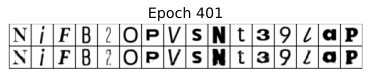

Epoch 401: train=208.297  (BCE=162.626 , KLD=45.671  ), val: 271.442 


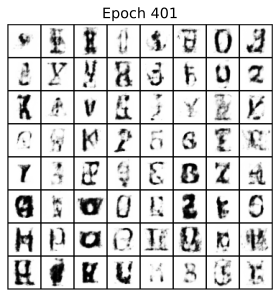

Epoch 402: train=208.390  (BCE=162.532 , KLD=45.857  ), val: 267.244 


Epoch 403: train=208.194  (BCE=162.364 , KLD=45.829  ), val: 270.591 


Epoch 404: train=208.157  (BCE=162.325 , KLD=45.832  ), val: 271.199 


Epoch 405: train=208.264  (BCE=162.353 , KLD=45.911  ), val: 273.114 


Epoch 406: train=207.911  (BCE=162.202 , KLD=45.710  ), val: 272.102 


Epoch 407: train=208.494  (BCE=162.692 , KLD=45.801  ), val: 274.130 


Epoch 408: train=208.139  (BCE=162.412 , KLD=45.727  ), val: 267.880 


Epoch 409: train=207.368  (BCE=161.769 , KLD=45.599  ), val: 273.265 


Epoch 410: train=207.609  (BCE=161.876 , KLD=45.733  ), val: 271.649 


Epoch 411: train=208.410  (BCE=162.532 , KLD=45.878  ), val: 270.055 


Epoch 412: train=208.345  (BCE=162.508 , KLD=45.837  ), val: 270.181 


Epoch 413: train=207.825  (BCE=161.972 , KLD=45.853  ), val: 271.724 


Epoch 414: train=208.245  (BCE=162.428 , KLD=45.817  ), val: 269.056 


Epoch 415: train=207.797  (BCE=162.116 , KLD=45.681  ), val: 270.050 


Epoch 416: train=207.382  (BCE=161.742 , KLD=45.640  ), val: 269.499 


Epoch 417: train=207.323  (BCE=161.588 , KLD=45.735  ), val: 270.863 


Epoch 418: train=208.748  (BCE=162.864 , KLD=45.884  ), val: 268.192 


Epoch 419: train=208.030  (BCE=162.334 , KLD=45.696  ), val: 270.868 


Epoch 420: train=208.603  (BCE=162.876 , KLD=45.727  ), val: 268.050 


Epoch 421: train=208.531  (BCE=162.686 , KLD=45.845  ), val: 273.043 


Epoch 422: train=209.227  (BCE=163.492 , KLD=45.735  ), val: 268.710 


Epoch 423: train=208.109  (BCE=162.323 , KLD=45.786  ), val: 269.366 


Epoch 424: train=207.361  (BCE=161.651 , KLD=45.711  ), val: 271.041 


Epoch 425: train=208.580  (BCE=162.625 , KLD=45.954  ), val: 271.920 


Epoch 426: train=207.762  (BCE=162.034 , KLD=45.728  ), val: 268.364 


Epoch 427: train=207.581  (BCE=161.932 , KLD=45.649  ), val: 270.005 


Epoch 428: train=208.302  (BCE=162.411 , KLD=45.891  ), val: 274.630 


Epoch 429: train=208.808  (BCE=163.104 , KLD=45.704  ), val: 270.241 


Epoch 430: train=207.785  (BCE=161.916 , KLD=45.869  ), val: 268.916 


Epoch 431: train=207.976  (BCE=162.164 , KLD=45.812  ), val: 270.426 


Epoch 432: train=207.938  (BCE=162.064 , KLD=45.874  ), val: 272.790 


Epoch 433: train=207.658  (BCE=161.948 , KLD=45.710  ), val: 271.050 


Epoch 434: train=207.247  (BCE=161.511 , KLD=45.735  ), val: 271.379 


Epoch 435: train=208.582  (BCE=162.787 , KLD=45.796  ), val: 269.800 


Epoch 436: train=208.646  (BCE=162.844 , KLD=45.802  ), val: 268.997 


Epoch 437: train=208.002  (BCE=162.238 , KLD=45.764  ), val: 269.517 


Epoch 438: train=207.273  (BCE=161.510 , KLD=45.763  ), val: 268.982 


Epoch 439: train=207.263  (BCE=161.351 , KLD=45.912  ), val: 268.422 


Epoch 440: train=207.120  (BCE=161.398 , KLD=45.721  ), val: 270.907 


Epoch 441: train=207.903  (BCE=162.018 , KLD=45.885  ), val: 271.708 


Epoch 442: train=207.085  (BCE=161.408 , KLD=45.677  ), val: 268.847 


Epoch 443: train=207.253  (BCE=161.545 , KLD=45.708  ), val: 270.716 


Epoch 444: train=208.099  (BCE=162.289 , KLD=45.811  ), val: 272.181 


Epoch 445: train=207.372  (BCE=161.717 , KLD=45.654  ), val: 267.835 


Epoch 446: train=208.384  (BCE=162.509 , KLD=45.875  ), val: 268.268 


Epoch 447: train=208.359  (BCE=162.585 , KLD=45.774  ), val: 272.925 


Epoch 448: train=208.031  (BCE=162.168 , KLD=45.862  ), val: 271.093 


Epoch 449: train=207.634  (BCE=161.848 , KLD=45.786  ), val: 270.732 


Epoch 450: train=207.783  (BCE=161.978 , KLD=45.805  ), val: 269.647 


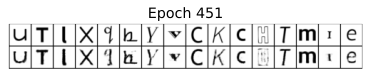

Epoch 451: train=207.663  (BCE=162.005 , KLD=45.658  ), val: 271.937 


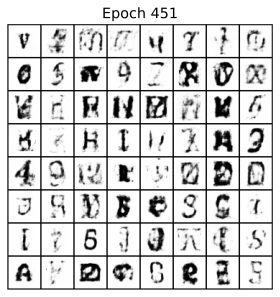

Epoch 452: train=207.839  (BCE=162.110 , KLD=45.729  ), val: 270.622 


Epoch 453: train=207.662  (BCE=161.986 , KLD=45.676  ), val: 269.071 


Epoch 454: train=207.458  (BCE=161.668 , KLD=45.790  ), val: 270.784 


Epoch 455: train=207.158  (BCE=161.542 , KLD=45.616  ), val: 271.318 


Epoch 456: train=207.237  (BCE=161.439 , KLD=45.798  ), val: 270.927 


Epoch 457: train=207.406  (BCE=161.673 , KLD=45.732  ), val: 273.319 


Epoch 458: train=207.448  (BCE=161.658 , KLD=45.790  ), val: 268.501 


Epoch 459: train=206.758  (BCE=161.039 , KLD=45.719  ), val: 271.631 


Epoch 460: train=207.350  (BCE=161.610 , KLD=45.740  ), val: 269.815 


Epoch 461: train=207.387  (BCE=161.523 , KLD=45.864  ), val: 270.879 


Epoch 462: train=207.199  (BCE=161.438 , KLD=45.761  ), val: 273.770 


Epoch 463: train=207.338  (BCE=161.773 , KLD=45.565  ), val: 270.550 


Epoch 464: train=207.629  (BCE=161.940 , KLD=45.689  ), val: 270.824 


Epoch 465: train=206.983  (BCE=161.278 , KLD=45.705  ), val: 274.960 


Epoch 466: train=207.703  (BCE=162.020 , KLD=45.683  ), val: 272.401 


Epoch 467: train=207.641  (BCE=162.024 , KLD=45.617  ), val: 271.786 


Epoch 468: train=208.076  (BCE=162.189 , KLD=45.887  ), val: 272.857 


Epoch 469: train=206.995  (BCE=161.227 , KLD=45.768  ), val: 272.099 


Epoch 470: train=206.298  (BCE=160.666 , KLD=45.631  ), val: 271.503 


Epoch 471: train=206.959  (BCE=161.336 , KLD=45.623  ), val: 269.374 


Epoch 472: train=206.925  (BCE=161.228 , KLD=45.697  ), val: 271.239 


Epoch 473: train=207.198  (BCE=161.495 , KLD=45.703  ), val: 271.790 


Epoch 474: train=207.050  (BCE=161.351 , KLD=45.699  ), val: 269.899 


Epoch 475: train=207.506  (BCE=161.600 , KLD=45.906  ), val: 269.600 


Epoch 476: train=207.450  (BCE=161.643 , KLD=45.807  ), val: 270.665 


Epoch 477: train=207.005  (BCE=161.320 , KLD=45.685  ), val: 272.834 


Epoch 478: train=206.836  (BCE=161.066 , KLD=45.770  ), val: 272.668 


Epoch 479: train=206.692  (BCE=160.989 , KLD=45.704  ), val: 272.080 


Epoch 480: train=207.504  (BCE=161.768 , KLD=45.736  ), val: 271.271 


Epoch 481: train=208.090  (BCE=162.388 , KLD=45.701  ), val: 269.998 


Epoch 482: train=206.919  (BCE=161.094 , KLD=45.825  ), val: 271.336 


Epoch 483: train=207.462  (BCE=161.612 , KLD=45.850  ), val: 272.241 


Epoch 484: train=206.531  (BCE=160.883 , KLD=45.649  ), val: 270.069 


Epoch 485: train=206.775  (BCE=161.033 , KLD=45.742  ), val: 271.023 


Epoch 486: train=206.195  (BCE=160.621 , KLD=45.574  ), val: 270.694 


Epoch 487: train=206.623  (BCE=160.992 , KLD=45.631  ), val: 275.624 


Epoch 488: train=206.897  (BCE=161.185 , KLD=45.711  ), val: 270.677 


Epoch 489: train=208.118  (BCE=162.248 , KLD=45.870  ), val: 270.844 


Epoch 490: train=207.038  (BCE=161.367 , KLD=45.671  ), val: 271.533 


Epoch 491: train=206.472  (BCE=160.833 , KLD=45.640  ), val: 270.066 


Epoch 492: train=206.988  (BCE=161.168 , KLD=45.820  ), val: 273.570 


Epoch 493: train=207.552  (BCE=161.798 , KLD=45.754  ), val: 273.121 


Epoch 494: train=207.209  (BCE=161.341 , KLD=45.867  ), val: 271.196 


Epoch 495: train=206.125  (BCE=160.625 , KLD=45.500  ), val: 270.502 


Epoch 496: train=207.118  (BCE=161.294 , KLD=45.824  ), val: 272.809 


Epoch 497: train=206.222  (BCE=160.379 , KLD=45.843  ), val: 272.065 


Epoch 498: train=206.857  (BCE=161.057 , KLD=45.800  ), val: 272.821 


Epoch 499: train=206.811  (BCE=161.243 , KLD=45.568  ), val: 272.051 


Epoch 500: train=207.270  (BCE=161.509 , KLD=45.761  ), val: 271.677 


In [20]:
model_name = f'vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
options = {
    'model_name': model_name,
    'input_dim': (50, 50),
    'z': 32,
    'hidden_dim': 1000,
    'n_hidden_encoder': 1,
    'n_hidden_decoder': 1,
    'lr': 1e-3,
    'beta': 0.50,
    'epochs': 500,
    'batch_size': 64
}

make_run(options)

vae_20240927-180814
Device:  cuda


Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

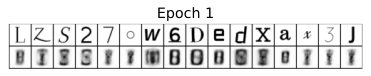

Epoch 001: train=295.979  (BCE=711.400 , KLD=7.137   ), val: 593.248 


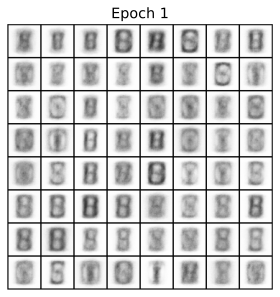

Epoch 002: train=232.339  (BCE=545.885 , KLD=8.741   ), val: 531.879 


Epoch 003: train=217.613  (BCE=504.182 , KLD=9.962   ), val: 489.166 


Epoch 004: train=203.030  (BCE=458.367 , KLD=12.302  ), val: 453.492 


Epoch 005: train=193.711  (BCE=429.903 , KLD=13.593  ), val: 438.770 


Epoch 006: train=187.762  (BCE=413.433 , KLD=13.993  ), val: 421.672 


Epoch 007: train=182.955  (BCE=399.929 , KLD=14.365  ), val: 404.506 


Epoch 008: train=178.111  (BCE=384.780 , KLD=15.124  ), val: 393.111 


Epoch 009: train=173.328  (BCE=369.980 , KLD=15.835  ), val: 382.212 


Epoch 010: train=169.698  (BCE=359.794 , KLD=16.113  ), val: 371.552 


Epoch 011: train=166.681  (BCE=350.717 , KLD=16.496  ), val: 363.747 


Epoch 012: train=164.055  (BCE=343.385 , KLD=16.688  ), val: 359.697 


Epoch 013: train=162.399  (BCE=338.486 , KLD=16.878  ), val: 357.435 


Epoch 014: train=159.930  (BCE=331.812 , KLD=17.003  ), val: 350.830 


Epoch 015: train=158.404  (BCE=327.096 , KLD=17.229  ), val: 344.020 


Epoch 016: train=156.132  (BCE=320.614 , KLD=17.429  ), val: 343.000 


Epoch 017: train=154.843  (BCE=316.696 , KLD=17.603  ), val: 334.727 


Epoch 018: train=153.395  (BCE=312.314 , KLD=17.793  ), val: 336.454 


Epoch 019: train=152.451  (BCE=309.432 , KLD=17.924  ), val: 329.188 


Epoch 020: train=151.292  (BCE=305.592 , KLD=18.159  ), val: 329.662 


Epoch 021: train=149.721  (BCE=301.514 , KLD=18.197  ), val: 328.686 


Epoch 022: train=148.747  (BCE=298.693 , KLD=18.294  ), val: 322.976 


Epoch 023: train=148.978  (BCE=298.789 , KLD=18.414  ), val: 318.974 


Epoch 024: train=147.540  (BCE=294.928 , KLD=18.481  ), val: 320.926 


Epoch 025: train=146.803  (BCE=292.318 , KLD=18.672  ), val: 320.051 


Epoch 026: train=146.371  (BCE=291.057 , KLD=18.718  ), val: 312.781 


Epoch 027: train=144.976  (BCE=287.312 , KLD=18.782  ), val: 310.068 


Epoch 028: train=145.070  (BCE=287.295 , KLD=18.845  ), val: 310.636 


Epoch 029: train=144.602  (BCE=285.965 , KLD=18.885  ), val: 313.499 


Epoch 030: train=144.090  (BCE=284.078 , KLD=19.037  ), val: 312.463 


Epoch 031: train=143.395  (BCE=281.934 , KLD=19.138  ), val: 311.605 


Epoch 032: train=143.580  (BCE=282.043 , KLD=19.227  ), val: 305.015 


Epoch 033: train=142.470  (BCE=279.148 , KLD=19.257  ), val: 306.438 


Epoch 034: train=142.265  (BCE=278.344 , KLD=19.330  ), val: 307.165 


Epoch 035: train=141.711  (BCE=276.519 , KLD=19.440  ), val: 300.933 


Epoch 036: train=141.365  (BCE=275.363 , KLD=19.512  ), val: 303.198 


Epoch 037: train=141.294  (BCE=274.940 , KLD=19.574  ), val: 302.051 


Epoch 038: train=140.840  (BCE=273.713 , KLD=19.597  ), val: 301.375 


Epoch 039: train=140.000  (BCE=271.906 , KLD=19.524  ), val: 301.322 


Epoch 040: train=139.821  (BCE=271.134 , KLD=19.604  ), val: 299.646 


Epoch 041: train=139.816  (BCE=270.748 , KLD=19.698  ), val: 299.781 


Epoch 042: train=139.235  (BCE=268.941 , KLD=19.787  ), val: 298.349 


Epoch 043: train=139.342  (BCE=269.482 , KLD=19.719  ), val: 299.353 


Epoch 044: train=138.776  (BCE=267.718 , KLD=19.806  ), val: 299.742 


Epoch 045: train=138.699  (BCE=267.094 , KLD=19.913  ), val: 299.225 


Epoch 046: train=138.170  (BCE=265.971 , KLD=19.864  ), val: 300.620 


Epoch 047: train=137.851  (BCE=264.906 , KLD=19.930  ), val: 296.602 


Epoch 048: train=137.398  (BCE=263.616 , KLD=19.970  ), val: 299.189 


Epoch 049: train=136.959  (BCE=262.556 , KLD=19.960  ), val: 295.129 


Epoch 050: train=136.822  (BCE=262.404 , KLD=19.913  ), val: 293.879 


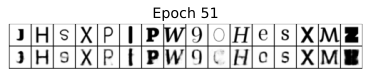

Epoch 051: train=136.720  (BCE=261.469 , KLD=20.083  ), val: 294.791 


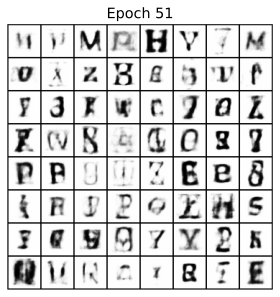

Epoch 052: train=136.204  (BCE=259.942 , KLD=20.142  ), val: 293.412 


Epoch 053: train=136.894  (BCE=261.474 , KLD=20.190  ), val: 294.474 


Epoch 054: train=136.370  (BCE=260.055 , KLD=20.218  ), val: 291.430 


Epoch 055: train=136.132  (BCE=259.552 , KLD=20.195  ), val: 294.022 


Epoch 056: train=135.319  (BCE=257.473 , KLD=20.206  ), val: 292.955 


Epoch 057: train=135.116  (BCE=256.616 , KLD=20.293  ), val: 292.437 


Epoch 058: train=135.269  (BCE=256.744 , KLD=20.357  ), val: 290.023 


Epoch 059: train=135.098  (BCE=256.587 , KLD=20.289  ), val: 289.639 


Epoch 060: train=134.727  (BCE=255.517 , KLD=20.325  ), val: 292.039 


Epoch 061: train=134.664  (BCE=255.237 , KLD=20.356  ), val: 292.840 


Epoch 062: train=134.457  (BCE=254.535 , KLD=20.402  ), val: 292.169 


Epoch 063: train=134.344  (BCE=254.060 , KLD=20.450  ), val: 289.601 


Epoch 064: train=134.090  (BCE=253.548 , KLD=20.419  ), val: 290.985 


Epoch 065: train=134.159  (BCE=253.523 , KLD=20.469  ), val: 293.818 


Epoch 066: train=134.150  (BCE=253.594 , KLD=20.445  ), val: 294.877 


Epoch 067: train=133.819  (BCE=252.692 , KLD=20.464  ), val: 287.969 


Epoch 068: train=133.607  (BCE=251.771 , KLD=20.561  ), val: 288.133 


Epoch 069: train=132.980  (BCE=250.441 , KLD=20.502  ), val: 292.851 


Epoch 070: train=132.544  (BCE=249.160 , KLD=20.550  ), val: 282.140 


Epoch 071: train=132.948  (BCE=249.872 , KLD=20.624  ), val: 287.609 


Epoch 072: train=132.782  (BCE=249.733 , KLD=20.556  ), val: 289.518 


Epoch 073: train=132.123  (BCE=247.857 , KLD=20.613  ), val: 288.889 


Epoch 074: train=132.518  (BCE=248.430 , KLD=20.716  ), val: 290.784 


Epoch 075: train=131.955  (BCE=247.423 , KLD=20.616  ), val: 292.026 


Epoch 076: train=132.060  (BCE=247.080 , KLD=20.768  ), val: 285.430 


Epoch 077: train=131.658  (BCE=246.759 , KLD=20.597  ), val: 286.726 


Epoch 078: train=131.537  (BCE=246.312 , KLD=20.633  ), val: 283.627 


Epoch 079: train=131.638  (BCE=246.340 , KLD=20.689  ), val: 288.642 


Epoch 080: train=131.410  (BCE=245.708 , KLD=20.704  ), val: 287.869 


Epoch 081: train=131.226  (BCE=245.319 , KLD=20.687  ), val: 284.119 


Epoch 082: train=131.105  (BCE=244.840 , KLD=20.731  ), val: 287.027 


Epoch 083: train=130.710  (BCE=243.900 , KLD=20.719  ), val: 283.420 


Epoch 084: train=131.153  (BCE=244.515 , KLD=20.842  ), val: 286.497 


Epoch 085: train=130.457  (BCE=243.052 , KLD=20.773  ), val: 286.012 


Epoch 086: train=130.912  (BCE=243.701 , KLD=20.895  ), val: 284.686 


Epoch 087: train=130.510  (BCE=243.191 , KLD=20.771  ), val: 286.009 


Epoch 088: train=130.039  (BCE=241.341 , KLD=20.939  ), val: 284.813 


Epoch 089: train=129.935  (BCE=241.287 , KLD=20.888  ), val: 286.887 


Epoch 090: train=129.863  (BCE=241.118 , KLD=20.885  ), val: 286.604 


Epoch 091: train=130.207  (BCE=241.945 , KLD=20.893  ), val: 286.465 


Epoch 092: train=129.719  (BCE=240.545 , KLD=20.938  ), val: 286.498 


Epoch 093: train=129.669  (BCE=240.695 , KLD=20.869  ), val: 284.107 


Epoch 094: train=129.359  (BCE=239.767 , KLD=20.907  ), val: 286.508 


Epoch 095: train=129.635  (BCE=240.304 , KLD=20.946  ), val: 281.110 


Epoch 096: train=129.204  (BCE=239.200 , KLD=20.953  ), val: 285.252 


Epoch 097: train=129.252  (BCE=239.355 , KLD=20.944  ), val: 284.220 


Epoch 098: train=129.230  (BCE=239.277 , KLD=20.950  ), val: 282.633 


Epoch 099: train=128.717  (BCE=237.962 , KLD=20.958  ), val: 285.683 


Epoch 100: train=128.979  (BCE=238.515 , KLD=20.983  ), val: 282.796 


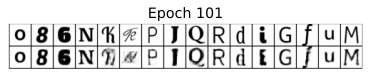

Epoch 101: train=128.729  (BCE=237.623 , KLD=21.050  ), val: 285.913 


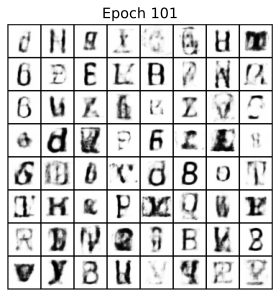

Epoch 102: train=128.484  (BCE=237.634 , KLD=20.894  ), val: 281.017 


Epoch 103: train=129.164  (BCE=238.823 , KLD=21.022  ), val: 282.639 


Epoch 104: train=128.217  (BCE=236.480 , KLD=21.016  ), val: 283.071 


Epoch 105: train=128.378  (BCE=236.592 , KLD=21.088  ), val: 285.024 


Epoch 106: train=128.472  (BCE=236.909 , KLD=21.068  ), val: 284.169 


Epoch 107: train=128.163  (BCE=236.314 , KLD=21.023  ), val: 279.305 


Epoch 108: train=127.945  (BCE=235.752 , KLD=21.027  ), val: 282.456 


Epoch 109: train=127.662  (BCE=235.125 , KLD=21.007  ), val: 287.991 


Epoch 110: train=127.583  (BCE=234.872 , KLD=21.022  ), val: 282.910 


Epoch 111: train=127.624  (BCE=234.696 , KLD=21.091  ), val: 278.811 


Epoch 112: train=128.118  (BCE=236.001 , KLD=21.074  ), val: 281.989 


Epoch 113: train=127.607  (BCE=234.774 , KLD=21.061  ), val: 285.222 


Epoch 114: train=127.345  (BCE=234.195 , KLD=21.042  ), val: 289.286 


Epoch 115: train=127.941  (BCE=235.329 , KLD=21.131  ), val: 281.085 


Epoch 116: train=126.795  (BCE=232.500 , KLD=21.122  ), val: 282.156 


Epoch 117: train=127.156  (BCE=233.226 , KLD=21.166  ), val: 283.921 


Epoch 118: train=126.987  (BCE=232.985 , KLD=21.121  ), val: 280.003 


Epoch 119: train=127.100  (BCE=232.911 , KLD=21.210  ), val: 283.731 


Epoch 120: train=127.047  (BCE=233.310 , KLD=21.077  ), val: 283.821 


Epoch 121: train=126.494  (BCE=231.715 , KLD=21.130  ), val: 283.539 


Epoch 122: train=127.152  (BCE=233.274 , KLD=21.152  ), val: 280.646 


Epoch 123: train=126.673  (BCE=232.121 , KLD=21.140  ), val: 281.053 


Epoch 124: train=126.352  (BCE=230.986 , KLD=21.224  ), val: 284.630 


Epoch 125: train=125.953  (BCE=230.449 , KLD=21.108  ), val: 282.533 


Epoch 126: train=126.178  (BCE=230.693 , KLD=21.188  ), val: 283.498 


Epoch 127: train=126.204  (BCE=230.627 , KLD=21.221  ), val: 285.058 


Epoch 128: train=126.683  (BCE=232.239 , KLD=21.117  ), val: 285.367 


Epoch 129: train=126.594  (BCE=231.522 , KLD=21.241  ), val: 282.871 


Epoch 130: train=125.954  (BCE=230.316 , KLD=21.142  ), val: 280.593 


Epoch 131: train=126.229  (BCE=230.474 , KLD=21.274  ), val: 282.473 


Epoch 132: train=125.813  (BCE=229.842 , KLD=21.173  ), val: 283.328 


Epoch 133: train=125.545  (BCE=228.841 , KLD=21.256  ), val: 280.467 


Epoch 134: train=125.734  (BCE=229.700 , KLD=21.159  ), val: 282.949 


Epoch 135: train=125.979  (BCE=229.640 , KLD=21.327  ), val: 281.318 


Epoch 136: train=125.578  (BCE=229.052 , KLD=21.223  ), val: 282.578 


Epoch 137: train=125.303  (BCE=228.341 , KLD=21.229  ), val: 280.650 


Epoch 138: train=125.134  (BCE=227.998 , KLD=21.210  ), val: 279.957 


Epoch 139: train=126.128  (BCE=230.308 , KLD=21.253  ), val: 282.346 


Epoch 140: train=126.060  (BCE=229.773 , KLD=21.344  ), val: 279.572 


Epoch 141: train=125.126  (BCE=228.078 , KLD=21.184  ), val: 283.777 


Epoch 142: train=124.992  (BCE=227.339 , KLD=21.285  ), val: 282.087 


Epoch 143: train=124.914  (BCE=227.281 , KLD=21.251  ), val: 279.629 


Epoch 144: train=124.736  (BCE=226.574 , KLD=21.317  ), val: 280.714 


Epoch 145: train=124.903  (BCE=227.135 , KLD=21.280  ), val: 280.236 


Epoch 146: train=124.513  (BCE=226.302 , KLD=21.245  ), val: 281.011 


Epoch 147: train=124.611  (BCE=226.469 , KLD=21.265  ), val: 280.787 


Epoch 148: train=125.000  (BCE=227.128 , KLD=21.343  ), val: 283.721 


Epoch 149: train=124.506  (BCE=226.064 , KLD=21.301  ), val: 282.304 


Epoch 150: train=124.376  (BCE=226.032 , KLD=21.227  ), val: 282.918 


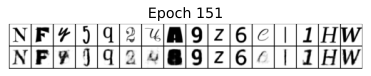

Epoch 151: train=124.507  (BCE=226.116 , KLD=21.288  ), val: 278.493 


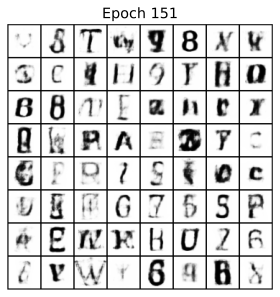

Epoch 152: train=124.515  (BCE=225.929 , KLD=21.339  ), val: 283.809 


Epoch 153: train=124.830  (BCE=226.471 , KLD=21.401  ), val: 281.721 


Epoch 154: train=124.405  (BCE=225.775 , KLD=21.310  ), val: 280.099 


Epoch 155: train=124.323  (BCE=225.504 , KLD=21.326  ), val: 283.002 


Epoch 156: train=124.373  (BCE=225.362 , KLD=21.392  ), val: 283.766 


Epoch 157: train=124.467  (BCE=225.627 , KLD=21.385  ), val: 279.437 


Epoch 158: train=124.208  (BCE=225.243 , KLD=21.319  ), val: 281.062 


Epoch 159: train=124.053  (BCE=224.548 , KLD=21.396  ), val: 283.857 


Epoch 160: train=124.266  (BCE=225.102 , KLD=21.391  ), val: 279.610 


Epoch 161: train=123.810  (BCE=224.052 , KLD=21.368  ), val: 279.522 


Epoch 162: train=123.692  (BCE=223.679 , KLD=21.388  ), val: 281.463 


Epoch 163: train=124.368  (BCE=225.397 , KLD=21.380  ), val: 289.002 


Epoch 164: train=124.060  (BCE=224.414 , KLD=21.434  ), val: 285.833 


Epoch 165: train=124.166  (BCE=224.901 , KLD=21.379  ), val: 279.786 


Epoch 166: train=123.965  (BCE=224.149 , KLD=21.441  ), val: 278.853 


Epoch 167: train=123.431  (BCE=222.929 , KLD=21.412  ), val: 280.444 


Epoch 168: train=123.595  (BCE=223.030 , KLD=21.489  ), val: 281.071 


Epoch 169: train=123.959  (BCE=224.362 , KLD=21.384  ), val: 283.367 


Epoch 170: train=123.454  (BCE=222.990 , KLD=21.411  ), val: 279.994 


Epoch 171: train=123.104  (BCE=222.143 , KLD=21.405  ), val: 281.550 


Epoch 172: train=123.161  (BCE=222.329 , KLD=21.393  ), val: 279.915 


Epoch 173: train=123.321  (BCE=222.662 , KLD=21.410  ), val: 278.388 


Epoch 174: train=123.374  (BCE=222.644 , KLD=21.448  ), val: 279.365 


Epoch 175: train=123.002  (BCE=221.411 , KLD=21.523  ), val: 281.656 


Epoch 176: train=123.255  (BCE=222.257 , KLD=21.470  ), val: 283.991 


Epoch 177: train=123.260  (BCE=222.385 , KLD=21.441  ), val: 286.204 


Epoch 178: train=123.236  (BCE=222.139 , KLD=21.488  ), val: 279.191 


Epoch 179: train=123.010  (BCE=221.494 , KLD=21.508  ), val: 282.099 


Epoch 180: train=122.854  (BCE=221.468 , KLD=21.417  ), val: 286.048 


Epoch 181: train=123.455  (BCE=222.461 , KLD=21.544  ), val: 278.408 


Epoch 182: train=123.128  (BCE=221.895 , KLD=21.481  ), val: 279.751 


Epoch 183: train=122.570  (BCE=220.506 , KLD=21.480  ), val: 281.058 


Epoch 184: train=122.670  (BCE=220.889 , KLD=21.446  ), val: 283.325 


Epoch 185: train=122.811  (BCE=221.320 , KLD=21.427  ), val: 277.860 


Epoch 186: train=122.827  (BCE=220.960 , KLD=21.527  ), val: 278.566 


Epoch 187: train=122.778  (BCE=220.746 , KLD=21.550  ), val: 285.547 


Epoch 188: train=122.568  (BCE=220.499 , KLD=21.480  ), val: 283.982 


Epoch 189: train=123.136  (BCE=221.631 , KLD=21.552  ), val: 282.079 


Epoch 190: train=122.716  (BCE=220.497 , KLD=21.573  ), val: 277.899 


Epoch 191: train=122.929  (BCE=221.284 , KLD=21.509  ), val: 282.693 


Epoch 192: train=122.580  (BCE=220.255 , KLD=21.549  ), val: 282.594 


Epoch 193: train=122.562  (BCE=220.135 , KLD=21.567  ), val: 286.585 


Epoch 194: train=122.786  (BCE=220.537 , KLD=21.607  ), val: 281.362 


Epoch 195: train=122.653  (BCE=220.422 , KLD=21.552  ), val: 281.271 


Epoch 196: train=122.761  (BCE=220.742 , KLD=21.540  ), val: 281.423 


Epoch 197: train=122.713  (BCE=220.511 , KLD=21.568  ), val: 281.879 


Epoch 198: train=122.535  (BCE=220.175 , KLD=21.540  ), val: 281.530 


Epoch 199: train=122.278  (BCE=219.611 , KLD=21.521  ), val: 285.061 


Epoch 200: train=122.322  (BCE=219.582 , KLD=21.556  ), val: 286.888 


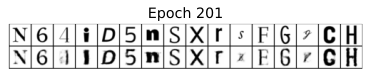

Epoch 201: train=122.203  (BCE=219.511 , KLD=21.499  ), val: 279.909 


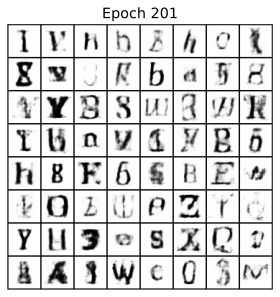

Epoch 202: train=122.264  (BCE=219.178 , KLD=21.621  ), val: 284.477 


Epoch 203: train=121.924  (BCE=218.530 , KLD=21.570  ), val: 276.986 


Epoch 204: train=122.185  (BCE=219.229 , KLD=21.558  ), val: 286.870 


Epoch 205: train=122.163  (BCE=219.334 , KLD=21.518  ), val: 279.536 


Epoch 206: train=121.879  (BCE=218.270 , KLD=21.607  ), val: 283.154 


Epoch 207: train=121.629  (BCE=217.969 , KLD=21.526  ), val: 280.257 


Epoch 208: train=121.874  (BCE=218.219 , KLD=21.616  ), val: 283.513 


Epoch 209: train=121.927  (BCE=218.592 , KLD=21.557  ), val: 280.534 


Epoch 210: train=122.325  (BCE=219.057 , KLD=21.689  ), val: 282.453 


Epoch 211: train=122.214  (BCE=219.244 , KLD=21.573  ), val: 281.315 


Epoch 212: train=121.799  (BCE=218.154 , KLD=21.586  ), val: 280.661 


Epoch 213: train=122.010  (BCE=218.436 , KLD=21.647  ), val: 284.422 


Epoch 214: train=122.039  (BCE=218.889 , KLD=21.552  ), val: 279.151 


Epoch 215: train=121.593  (BCE=217.595 , KLD=21.597  ), val: 283.530 


Epoch 216: train=121.773  (BCE=217.811 , KLD=21.655  ), val: 279.564 


Epoch 217: train=121.501  (BCE=217.090 , KLD=21.665  ), val: 279.222 


Epoch 218: train=121.567  (BCE=217.103 , KLD=21.704  ), val: 278.058 


Epoch 219: train=121.899  (BCE=218.249 , KLD=21.625  ), val: 281.478 


Epoch 220: train=121.914  (BCE=218.126 , KLD=21.665  ), val: 286.285 


Epoch 221: train=121.981  (BCE=218.250 , KLD=21.676  ), val: 282.593 


Epoch 222: train=121.303  (BCE=216.871 , KLD=21.597  ), val: 280.836 


Epoch 223: train=120.910  (BCE=216.135 , KLD=21.535  ), val: 278.377 


Epoch 224: train=121.085  (BCE=216.539 , KLD=21.544  ), val: 282.441 


Epoch 225: train=121.074  (BCE=216.157 , KLD=21.632  ), val: 282.749 


Epoch 226: train=121.303  (BCE=216.399 , KLD=21.715  ), val: 281.891 


Epoch 227: train=121.477  (BCE=216.893 , KLD=21.700  ), val: 286.386 


Epoch 228: train=121.331  (BCE=216.755 , KLD=21.643  ), val: 279.411 


Epoch 229: train=121.458  (BCE=216.893 , KLD=21.688  ), val: 284.684 


Epoch 230: train=121.107  (BCE=216.301 , KLD=21.616  ), val: 282.232 


Epoch 231: train=120.972  (BCE=215.871 , KLD=21.640  ), val: 279.594 


Epoch 232: train=121.263  (BCE=216.633 , KLD=21.631  ), val: 280.835 


Epoch 233: train=121.232  (BCE=216.525 , KLD=21.638  ), val: 279.136 


Epoch 234: train=120.875  (BCE=215.428 , KLD=21.690  ), val: 283.485 


Epoch 235: train=120.905  (BCE=216.156 , KLD=21.527  ), val: 280.743 


Epoch 236: train=120.977  (BCE=215.816 , KLD=21.657  ), val: 281.640 


Epoch 237: train=121.035  (BCE=216.044 , KLD=21.636  ), val: 281.018 


Epoch 238: train=120.864  (BCE=215.345 , KLD=21.704  ), val: 285.956 


Epoch 239: train=120.690  (BCE=215.288 , KLD=21.609  ), val: 285.163 


Epoch 240: train=120.662  (BCE=215.008 , KLD=21.662  ), val: 280.662 


Epoch 241: train=120.987  (BCE=215.584 , KLD=21.721  ), val: 280.707 


Epoch 242: train=120.638  (BCE=214.770 , KLD=21.706  ), val: 278.709 


Epoch 243: train=120.764  (BCE=215.106 , KLD=21.701  ), val: 281.678 


Epoch 244: train=121.193  (BCE=215.943 , KLD=21.760  ), val: 279.220 


Epoch 245: train=120.714  (BCE=215.201 , KLD=21.646  ), val: 278.279 


Epoch 246: train=120.564  (BCE=214.959 , KLD=21.613  ), val: 279.238 


Epoch 247: train=120.680  (BCE=214.518 , KLD=21.795  ), val: 284.065 


Epoch 248: train=120.712  (BCE=215.085 , KLD=21.674  ), val: 282.940 


Epoch 249: train=120.401  (BCE=214.621 , KLD=21.595  ), val: 281.249 


Epoch 250: train=120.830  (BCE=214.933 , KLD=21.785  ), val: 283.015 


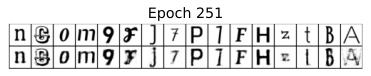

Epoch 251: train=120.864  (BCE=215.486 , KLD=21.669  ), val: 282.813 


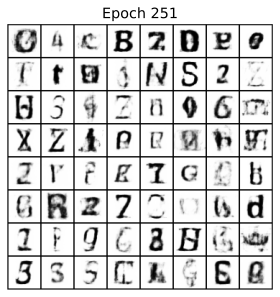

Epoch 252: train=120.361  (BCE=214.322 , KLD=21.645  ), val: 283.884 


Epoch 253: train=121.029  (BCE=215.688 , KLD=21.721  ), val: 284.161 


Epoch 254: train=120.998  (BCE=215.213 , KLD=21.821  ), val: 284.910 


Epoch 255: train=120.623  (BCE=214.680 , KLD=21.719  ), val: 282.574 


Epoch 256: train=120.532  (BCE=214.556 , KLD=21.694  ), val: 283.547 


Epoch 257: train=120.018  (BCE=213.361 , KLD=21.671  ), val: 289.621 


Epoch 258: train=120.374  (BCE=214.068 , KLD=21.717  ), val: 281.037 


Epoch 259: train=120.301  (BCE=213.849 , KLD=21.726  ), val: 282.928 


Epoch 260: train=120.190  (BCE=213.632 , KLD=21.710  ), val: 283.357 


Epoch 261: train=120.367  (BCE=213.730 , KLD=21.797  ), val: 280.524 


Epoch 262: train=119.978  (BCE=213.085 , KLD=21.715  ), val: 280.134 


Epoch 263: train=120.540  (BCE=214.204 , KLD=21.787  ), val: 283.627 


Epoch 264: train=120.977  (BCE=215.414 , KLD=21.757  ), val: 280.565 


Epoch 265: train=119.642  (BCE=212.231 , KLD=21.718  ), val: 281.325 


Epoch 266: train=120.076  (BCE=213.317 , KLD=21.718  ), val: 283.349 


Epoch 267: train=120.316  (BCE=213.970 , KLD=21.705  ), val: 281.746 


Epoch 268: train=120.155  (BCE=213.469 , KLD=21.730  ), val: 285.622 


Epoch 269: train=120.363  (BCE=213.887 , KLD=21.755  ), val: 279.709 


Epoch 270: train=120.118  (BCE=213.255 , KLD=21.760  ), val: 279.253 


Epoch 271: train=119.822  (BCE=212.456 , KLD=21.775  ), val: 286.733 


Epoch 272: train=119.742  (BCE=212.877 , KLD=21.620  ), val: 283.922 


Epoch 273: train=119.811  (BCE=212.561 , KLD=21.742  ), val: 282.727 


Epoch 274: train=119.850  (BCE=212.876 , KLD=21.687  ), val: 284.172 


Epoch 275: train=120.294  (BCE=213.591 , KLD=21.786  ), val: 281.939 


Epoch 276: train=120.280  (BCE=213.534 , KLD=21.792  ), val: 282.837 


Epoch 277: train=120.290  (BCE=213.409 , KLD=21.829  ), val: 282.903 


Epoch 278: train=120.639  (BCE=214.042 , KLD=21.889  ), val: 285.739 


Epoch 279: train=119.987  (BCE=212.559 , KLD=21.852  ), val: 279.348 


Epoch 280: train=119.644  (BCE=212.088 , KLD=21.755  ), val: 280.244 


Epoch 281: train=120.142  (BCE=213.003 , KLD=21.838  ), val: 283.095 


Epoch 282: train=119.955  (BCE=212.880 , KLD=21.752  ), val: 283.326 


Epoch 283: train=119.747  (BCE=212.234 , KLD=21.784  ), val: 285.188 


Epoch 284: train=119.570  (BCE=211.950 , KLD=21.744  ), val: 283.738 


Epoch 285: train=120.012  (BCE=212.597 , KLD=21.858  ), val: 280.896 


Epoch 286: train=119.710  (BCE=211.851 , KLD=21.856  ), val: 282.311 


Epoch 287: train=119.895  (BCE=212.635 , KLD=21.775  ), val: 280.164 


Epoch 288: train=119.877  (BCE=212.396 , KLD=21.824  ), val: 284.265 


Epoch 289: train=119.708  (BCE=212.262 , KLD=21.752  ), val: 283.057 


Epoch 290: train=119.231  (BCE=211.215 , KLD=21.716  ), val: 282.766 


Epoch 291: train=119.450  (BCE=211.558 , KLD=21.767  ), val: 284.112 


Epoch 292: train=119.418  (BCE=211.146 , KLD=21.850  ), val: 281.272 


Epoch 293: train=119.118  (BCE=210.945 , KLD=21.712  ), val: 285.099 


Epoch 294: train=119.581  (BCE=211.829 , KLD=21.781  ), val: 283.683 


Epoch 295: train=119.551  (BCE=212.069 , KLD=21.702  ), val: 286.101 


Epoch 296: train=119.582  (BCE=211.731 , KLD=21.806  ), val: 281.914 


Epoch 297: train=119.677  (BCE=211.656 , KLD=21.884  ), val: 281.349 


Epoch 298: train=119.879  (BCE=212.267 , KLD=21.858  ), val: 282.908 


Epoch 299: train=119.596  (BCE=211.562 , KLD=21.857  ), val: 282.972 


Epoch 300: train=119.741  (BCE=211.954 , KLD=21.850  ), val: 282.595 


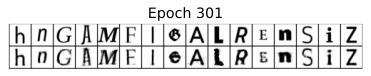

Epoch 301: train=119.475  (BCE=211.379 , KLD=21.827  ), val: 281.955 


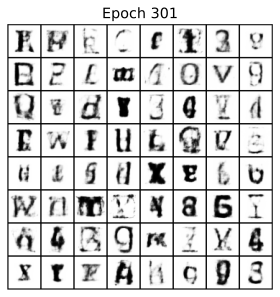

Epoch 302: train=119.365  (BCE=211.132 , KLD=21.820  ), val: 282.340 


Epoch 303: train=119.109  (BCE=210.516 , KLD=21.814  ), val: 282.589 


Epoch 304: train=119.325  (BCE=211.088 , KLD=21.806  ), val: 286.250 


Epoch 305: train=119.565  (BCE=211.563 , KLD=21.838  ), val: 282.888 


Epoch 306: train=119.407  (BCE=210.990 , KLD=21.882  ), val: 279.657 


Epoch 307: train=119.627  (BCE=211.726 , KLD=21.835  ), val: 279.870 


Epoch 308: train=119.058  (BCE=210.594 , KLD=21.763  ), val: 289.441 


Epoch 309: train=119.362  (BCE=211.399 , KLD=21.752  ), val: 283.179 


Epoch 310: train=119.434  (BCE=211.386 , KLD=21.800  ), val: 289.617 


Epoch 311: train=119.240  (BCE=210.582 , KLD=21.880  ), val: 283.219 


Epoch 312: train=119.210  (BCE=210.430 , KLD=21.899  ), val: 282.250 


Epoch 313: train=119.092  (BCE=210.420 , KLD=21.827  ), val: 285.220 


Epoch 314: train=119.043  (BCE=210.044 , KLD=21.891  ), val: 280.051 


Epoch 315: train=118.975  (BCE=209.847 , KLD=21.898  ), val: 285.756 


Epoch 316: train=119.484  (BCE=211.179 , KLD=21.883  ), val: 284.629 


Epoch 317: train=119.127  (BCE=210.318 , KLD=21.875  ), val: 282.985 


Epoch 318: train=119.149  (BCE=210.090 , KLD=21.946  ), val: 280.550 


Epoch 319: train=119.152  (BCE=210.489 , KLD=21.848  ), val: 282.728 


Epoch 320: train=119.383  (BCE=211.185 , KLD=21.818  ), val: 278.973 


Epoch 321: train=119.015  (BCE=209.721 , KLD=21.954  ), val: 285.258 


Epoch 322: train=118.805  (BCE=209.442 , KLD=21.893  ), val: 281.346 


Epoch 323: train=119.405  (BCE=210.993 , KLD=21.880  ), val: 286.203 


Epoch 324: train=118.810  (BCE=209.523 , KLD=21.876  ), val: 284.477 


Epoch 325: train=119.073  (BCE=210.487 , KLD=21.799  ), val: 283.303 


Epoch 326: train=119.146  (BCE=210.238 , KLD=21.906  ), val: 289.070 


Epoch 327: train=118.851  (BCE=209.693 , KLD=21.858  ), val: 280.454 


Epoch 328: train=118.781  (BCE=209.205 , KLD=21.937  ), val: 293.204 


Epoch 329: train=119.090  (BCE=210.537 , KLD=21.797  ), val: 282.756 


Epoch 330: train=119.198  (BCE=210.397 , KLD=21.900  ), val: 282.808 


Epoch 331: train=119.384  (BCE=210.865 , KLD=21.899  ), val: 288.515 


Epoch 332: train=118.636  (BCE=209.398 , KLD=21.798  ), val: 285.992 


Epoch 333: train=118.850  (BCE=209.366 , KLD=21.940  ), val: 281.403 


Epoch 334: train=119.098  (BCE=210.281 , KLD=21.866  ), val: 286.933 


Epoch 335: train=118.925  (BCE=210.014 , KLD=21.824  ), val: 282.050 


Epoch 336: train=119.051  (BCE=210.029 , KLD=21.900  ), val: 285.694 


Epoch 337: train=118.731  (BCE=209.640 , KLD=21.797  ), val: 283.624 


Epoch 338: train=118.785  (BCE=209.484 , KLD=21.870  ), val: 284.029 


Epoch 339: train=119.314  (BCE=210.639 , KLD=21.911  ), val: 283.430 


Epoch 340: train=118.411  (BCE=208.422 , KLD=21.901  ), val: 287.850 


Epoch 341: train=118.432  (BCE=208.947 , KLD=21.783  ), val: 280.301 


Epoch 342: train=118.453  (BCE=208.539 , KLD=21.899  ), val: 281.738 


Epoch 343: train=118.528  (BCE=208.605 , KLD=21.929  ), val: 287.020 


Epoch 344: train=118.370  (BCE=208.473 , KLD=21.863  ), val: 285.136 


Epoch 345: train=118.635  (BCE=208.831 , KLD=21.939  ), val: 281.959 


Epoch 346: train=118.281  (BCE=208.320 , KLD=21.845  ), val: 282.392 


Epoch 347: train=118.380  (BCE=208.272 , KLD=21.919  ), val: 283.421 


Epoch 348: train=118.764  (BCE=209.201 , KLD=21.927  ), val: 286.700 


Epoch 349: train=119.036  (BCE=210.343 , KLD=21.812  ), val: 289.970 


Epoch 350: train=118.362  (BCE=208.056 , KLD=21.962  ), val: 283.489 


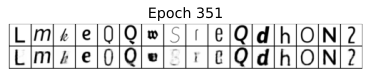

Epoch 351: train=118.583  (BCE=208.555 , KLD=21.976  ), val: 288.523 


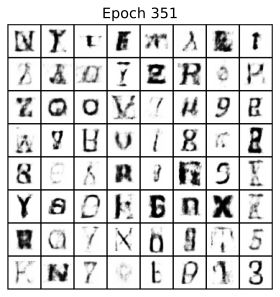

Epoch 352: train=119.385  (BCE=210.587 , KLD=21.969  ), val: 285.176 


Epoch 353: train=118.231  (BCE=208.089 , KLD=21.872  ), val: 286.101 


Epoch 354: train=118.911  (BCE=209.712 , KLD=21.891  ), val: 282.136 


Epoch 355: train=118.056  (BCE=207.648 , KLD=21.873  ), val: 284.395 


Epoch 356: train=118.531  (BCE=208.891 , KLD=21.859  ), val: 283.986 


Epoch 357: train=118.913  (BCE=209.481 , KLD=21.950  ), val: 282.781 


Epoch 358: train=118.506  (BCE=208.635 , KLD=21.907  ), val: 284.808 


Epoch 359: train=118.433  (BCE=208.427 , KLD=21.914  ), val: 285.315 


Epoch 360: train=118.024  (BCE=207.478 , KLD=21.896  ), val: 285.176 


Epoch 361: train=118.055  (BCE=207.697 , KLD=21.860  ), val: 282.985 


Epoch 362: train=118.343  (BCE=208.421 , KLD=21.859  ), val: 285.825 


Epoch 363: train=118.638  (BCE=208.848 , KLD=21.937  ), val: 282.606 


Epoch 364: train=118.435  (BCE=208.053 , KLD=22.008  ), val: 285.722 


Epoch 365: train=118.203  (BCE=207.965 , KLD=21.886  ), val: 282.354 


Epoch 366: train=118.390  (BCE=208.222 , KLD=21.938  ), val: 285.083 


Epoch 367: train=118.172  (BCE=207.775 , KLD=21.914  ), val: 284.811 


Epoch 368: train=118.202  (BCE=207.577 , KLD=21.982  ), val: 282.606 


Epoch 369: train=118.152  (BCE=207.569 , KLD=21.953  ), val: 284.779 


Epoch 370: train=118.031  (BCE=207.368 , KLD=21.928  ), val: 283.338 


Epoch 371: train=118.277  (BCE=207.702 , KLD=21.997  ), val: 289.098 


Epoch 372: train=118.535  (BCE=208.677 , KLD=21.915  ), val: 290.258 


Epoch 373: train=118.812  (BCE=208.903 , KLD=22.032  ), val: 281.213 


Epoch 374: train=117.843  (BCE=206.945 , KLD=21.916  ), val: 284.720 


Epoch 375: train=118.715  (BCE=208.858 , KLD=21.982  ), val: 284.301 


Epoch 376: train=118.198  (BCE=207.893 , KLD=21.900  ), val: 282.645 


Epoch 377: train=118.177  (BCE=207.479 , KLD=21.991  ), val: 282.215 


Epoch 378: train=118.009  (BCE=206.875 , KLD=22.037  ), val: 284.967 


Epoch 379: train=118.047  (BCE=207.432 , KLD=21.921  ), val: 283.723 


Epoch 380: train=118.339  (BCE=208.115 , KLD=21.933  ), val: 283.393 


Epoch 381: train=117.822  (BCE=206.906 , KLD=21.912  ), val: 277.835 


Epoch 382: train=118.088  (BCE=207.192 , KLD=22.007  ), val: 284.697 


Epoch 383: train=117.923  (BCE=206.733 , KLD=22.019  ), val: 283.320 


Epoch 384: train=118.710  (BCE=208.622 , KLD=22.038  ), val: 288.264 


Epoch 385: train=118.160  (BCE=207.826 , KLD=21.893  ), val: 289.027 


Epoch 386: train=118.244  (BCE=207.550 , KLD=22.015  ), val: 284.411 


Epoch 387: train=118.380  (BCE=207.883 , KLD=22.016  ), val: 283.192 


Epoch 388: train=118.031  (BCE=206.862 , KLD=22.054  ), val: 285.471 


Epoch 389: train=117.875  (BCE=206.965 , KLD=21.930  ), val: 283.477 


Epoch 390: train=117.511  (BCE=206.050 , KLD=21.932  ), val: 284.936 


Epoch 391: train=118.149  (BCE=207.493 , KLD=21.970  ), val: 286.384 


Epoch 392: train=118.169  (BCE=207.526 , KLD=21.974  ), val: 283.194 


Epoch 393: train=118.225  (BCE=207.293 , KLD=22.067  ), val: 288.351 


Epoch 394: train=118.280  (BCE=207.733 , KLD=21.992  ), val: 283.364 


Epoch 395: train=117.868  (BCE=206.906 , KLD=21.941  ), val: 285.412 


Epoch 396: train=117.797  (BCE=206.566 , KLD=21.981  ), val: 284.128 


Epoch 397: train=117.779  (BCE=206.411 , KLD=22.009  ), val: 282.709 


Epoch 398: train=117.772  (BCE=206.778 , KLD=21.913  ), val: 284.099 


Epoch 399: train=117.854  (BCE=206.685 , KLD=21.987  ), val: 282.450 


Epoch 400: train=117.781  (BCE=206.728 , KLD=21.931  ), val: 288.994 


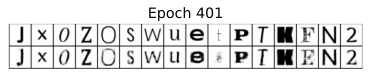

Epoch 401: train=118.153  (BCE=207.404 , KLD=21.995  ), val: 291.336 


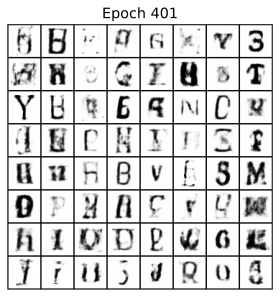

Epoch 402: train=117.811  (BCE=206.301 , KLD=22.057  ), val: 287.907 


Epoch 403: train=118.309  (BCE=207.726 , KLD=22.011  ), val: 288.259 


Epoch 404: train=117.981  (BCE=207.355 , KLD=21.900  ), val: 285.336 


Epoch 405: train=117.946  (BCE=206.639 , KLD=22.057  ), val: 286.387 


Epoch 406: train=118.783  (BCE=208.626 , KLD=22.083  ), val: 284.028 


Epoch 407: train=117.594  (BCE=206.025 , KLD=21.990  ), val: 285.238 


Epoch 408: train=117.741  (BCE=206.624 , KLD=21.932  ), val: 282.063 


Epoch 409: train=117.573  (BCE=205.837 , KLD=22.024  ), val: 283.924 


Epoch 410: train=117.573  (BCE=206.051 , KLD=21.970  ), val: 281.888 


Epoch 411: train=118.243  (BCE=207.503 , KLD=22.026  ), val: 282.668 


Epoch 412: train=118.059  (BCE=206.767 , KLD=22.095  ), val: 286.402 


Epoch 413: train=117.997  (BCE=206.961 , KLD=22.008  ), val: 287.976 


Epoch 414: train=117.772  (BCE=206.659 , KLD=21.943  ), val: 285.623 


Epoch 415: train=117.595  (BCE=205.922 , KLD=22.016  ), val: 283.634 


Epoch 416: train=117.602  (BCE=206.298 , KLD=21.927  ), val: 283.601 


Epoch 417: train=117.655  (BCE=206.354 , KLD=21.946  ), val: 283.162 


Epoch 418: train=117.487  (BCE=205.939 , KLD=21.944  ), val: 287.726 


Epoch 419: train=117.819  (BCE=206.617 , KLD=21.983  ), val: 286.040 


Epoch 420: train=117.364  (BCE=205.588 , KLD=21.956  ), val: 286.521 


Epoch 421: train=117.552  (BCE=206.176 , KLD=21.926  ), val: 287.812 


Epoch 422: train=117.890  (BCE=206.599 , KLD=22.031  ), val: 285.379 


Epoch 423: train=117.672  (BCE=206.107 , KLD=22.018  ), val: 284.807 


Epoch 424: train=117.407  (BCE=205.743 , KLD=21.943  ), val: 281.694 


Epoch 425: train=118.053  (BCE=206.802 , KLD=22.083  ), val: 281.166 


Epoch 426: train=117.488  (BCE=205.888 , KLD=21.958  ), val: 282.419 


Epoch 427: train=117.347  (BCE=205.357 , KLD=22.003  ), val: 287.172 


Epoch 428: train=117.640  (BCE=205.866 , KLD=22.058  ), val: 285.062 


Epoch 429: train=117.377  (BCE=205.452 , KLD=21.998  ), val: 288.613 


Epoch 430: train=118.085  (BCE=207.150 , KLD=22.016  ), val: 285.089 


Epoch 431: train=117.415  (BCE=205.274 , KLD=22.066  ), val: 290.889 


Epoch 432: train=117.462  (BCE=205.650 , KLD=22.001  ), val: 281.479 


Epoch 433: train=117.602  (BCE=205.735 , KLD=22.067  ), val: 284.095 


Epoch 434: train=117.689  (BCE=206.010 , KLD=22.053  ), val: 284.951 


Epoch 435: train=117.604  (BCE=205.950 , KLD=22.015  ), val: 284.431 


Epoch 436: train=117.284  (BCE=205.212 , KLD=21.999  ), val: 281.906 


Epoch 437: train=117.088  (BCE=204.863 , KLD=21.964  ), val: 282.961 


Epoch 438: train=117.455  (BCE=205.362 , KLD=22.069  ), val: 289.103 


Epoch 439: train=117.511  (BCE=205.894 , KLD=21.971  ), val: 287.259 


Epoch 440: train=117.223  (BCE=205.432 , KLD=21.906  ), val: 285.615 


Epoch 441: train=117.507  (BCE=205.362 , KLD=22.102  ), val: 285.765 


Epoch 442: train=117.154  (BCE=204.968 , KLD=21.979  ), val: 289.691 


Epoch 443: train=117.518  (BCE=206.026 , KLD=21.942  ), val: 288.844 


Epoch 444: train=117.622  (BCE=205.984 , KLD=22.018  ), val: 288.503 


Epoch 445: train=117.666  (BCE=205.936 , KLD=22.057  ), val: 283.287 


Epoch 446: train=117.391  (BCE=205.711 , KLD=21.942  ), val: 286.200 


Epoch 447: train=117.439  (BCE=205.486 , KLD=22.028  ), val: 285.464 


Epoch 448: train=117.315  (BCE=205.412 , KLD=21.969  ), val: 286.490 


Epoch 449: train=117.199  (BCE=204.967 , KLD=22.008  ), val: 288.220 


Epoch 450: train=117.926  (BCE=206.592 , KLD=22.056  ), val: 286.499 


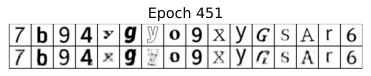

Epoch 451: train=117.642  (BCE=205.904 , KLD=22.050  ), val: 284.408 


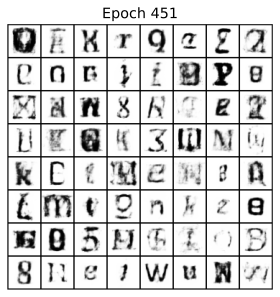

Epoch 452: train=117.032  (BCE=204.579 , KLD=22.000  ), val: 284.804 


Epoch 453: train=117.201  (BCE=204.794 , KLD=22.052  ), val: 283.036 


Epoch 454: train=117.122  (BCE=204.548 , KLD=22.064  ), val: 287.387 


Epoch 455: train=117.458  (BCE=205.610 , KLD=22.009  ), val: 290.409 


Epoch 456: train=117.600  (BCE=205.815 , KLD=22.046  ), val: 284.607 


Epoch 457: train=117.461  (BCE=205.232 , KLD=22.105  ), val: 287.538 


Epoch 458: train=117.426  (BCE=205.491 , KLD=22.019  ), val: 285.026 


Epoch 459: train=117.524  (BCE=205.735 , KLD=22.019  ), val: 284.060 


Epoch 460: train=116.947  (BCE=204.237 , KLD=22.033  ), val: 284.829 


Epoch 461: train=117.274  (BCE=204.963 , KLD=22.055  ), val: 285.931 


Epoch 462: train=117.311  (BCE=204.948 , KLD=22.082  ), val: 287.233 


Epoch 463: train=117.427  (BCE=205.495 , KLD=22.018  ), val: 284.897 


Epoch 464: train=117.514  (BCE=205.519 , KLD=22.067  ), val: 290.971 


Epoch 465: train=117.206  (BCE=205.051 , KLD=21.991  ), val: 283.357 


Epoch 466: train=117.339  (BCE=205.156 , KLD=22.048  ), val: 288.416 


Epoch 467: train=116.963  (BCE=203.997 , KLD=22.103  ), val: 289.973 


Epoch 468: train=116.671  (BCE=203.899 , KLD=21.944  ), val: 289.795 


Epoch 469: train=117.136  (BCE=204.910 , KLD=21.982  ), val: 286.389 


Epoch 470: train=117.100  (BCE=204.270 , KLD=22.120  ), val: 287.016 


Epoch 471: train=117.231  (BCE=204.866 , KLD=22.053  ), val: 287.670 


Epoch 472: train=117.146  (BCE=204.941 , KLD=21.981  ), val: 289.839 


Epoch 473: train=117.074  (BCE=204.267 , KLD=22.105  ), val: 285.185 


Epoch 474: train=116.990  (BCE=204.327 , KLD=22.037  ), val: 288.845 


Epoch 475: train=117.349  (BCE=205.337 , KLD=22.009  ), val: 289.928 


Epoch 476: train=117.219  (BCE=204.550 , KLD=22.124  ), val: 285.351 


Epoch 477: train=117.236  (BCE=204.764 , KLD=22.082  ), val: 283.290 


Epoch 478: train=117.226  (BCE=204.758 , KLD=22.077  ), val: 287.577 


Epoch 479: train=117.014  (BCE=204.248 , KLD=22.072  ), val: 285.756 


Epoch 480: train=117.214  (BCE=205.081 , KLD=21.989  ), val: 287.798 


Epoch 481: train=116.974  (BCE=204.138 , KLD=22.074  ), val: 286.267 


Epoch 482: train=116.837  (BCE=203.813 , KLD=22.070  ), val: 285.869 


Epoch 483: train=117.272  (BCE=204.926 , KLD=22.064  ), val: 286.316 


Epoch 484: train=117.200  (BCE=204.775 , KLD=22.057  ), val: 286.899 


Epoch 485: train=117.148  (BCE=204.243 , KLD=22.157  ), val: 284.619 


Epoch 486: train=116.757  (BCE=203.914 , KLD=21.995  ), val: 283.366 


Epoch 487: train=116.811  (BCE=203.806 , KLD=22.055  ), val: 286.454 


Epoch 488: train=116.790  (BCE=203.704 , KLD=22.068  ), val: 283.710 


Epoch 489: train=117.225  (BCE=204.799 , KLD=22.066  ), val: 286.730 


Epoch 490: train=117.426  (BCE=205.308 , KLD=22.064  ), val: 287.496 


Epoch 491: train=116.648  (BCE=203.508 , KLD=22.028  ), val: 283.917 


Epoch 492: train=116.958  (BCE=203.789 , KLD=22.151  ), val: 286.800 


Epoch 493: train=117.099  (BCE=204.493 , KLD=22.063  ), val: 285.783 


Epoch 494: train=116.720  (BCE=203.521 , KLD=22.070  ), val: 285.362 


Epoch 495: train=116.957  (BCE=204.075 , KLD=22.080  ), val: 284.779 


Epoch 496: train=117.137  (BCE=204.155 , KLD=22.172  ), val: 286.878 


Epoch 497: train=117.006  (BCE=204.082 , KLD=22.108  ), val: 284.901 


Epoch 498: train=116.802  (BCE=203.788 , KLD=22.054  ), val: 286.112 


Epoch 499: train=117.151  (BCE=204.497 , KLD=22.095  ), val: 288.498 


Epoch 500: train=117.095  (BCE=204.247 , KLD=22.123  ), val: 287.544 


In [21]:
model_name = f'vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
options = {
    'model_name': model_name,
    'input_dim': (50, 50),
    'z': 32,
    'hidden_dim': 1000,
    'n_hidden_encoder': 1,
    'n_hidden_decoder': 1,
    'lr': 1e-3,
    'beta': 0.80,
    'epochs': 500,
    'batch_size': 64
}

make_run(options)

vae_20240927-185653
Device:  cuda


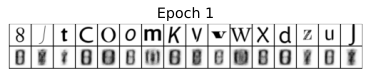

Epoch 001: train=295.441  (BCE=715.289 , KLD=5.828   ), val: 619.177 


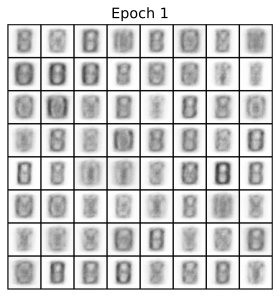

Epoch 002: train=240.465  (BCE=570.784 , KLD=7.595   ), val: 546.042 


Epoch 003: train=223.740  (BCE=521.464 , KLD=9.471   ), val: 515.833 


Epoch 004: train=216.838  (BCE=500.434 , KLD=10.415  ), val: 498.716 


Epoch 005: train=208.086  (BCE=474.111 , KLD=11.526  ), val: 475.772 


Epoch 006: train=200.958  (BCE=453.240 , KLD=12.289  ), val: 459.802 


Epoch 007: train=194.889  (BCE=435.165 , KLD=13.014  ), val: 438.665 


Epoch 008: train=189.012  (BCE=419.125 , KLD=13.352  ), val: 426.461 


Epoch 009: train=185.272  (BCE=408.751 , KLD=13.607  ), val: 424.671 


Epoch 010: train=181.156  (BCE=397.645 , KLD=13.811  ), val: 408.888 


Epoch 011: train=176.668  (BCE=384.568 , KLD=14.276  ), val: 394.271 


Epoch 012: train=172.861  (BCE=373.335 , KLD=14.705  ), val: 391.898 


Epoch 013: train=169.589  (BCE=363.622 , KLD=15.087  ), val: 378.675 


Epoch 014: train=167.130  (BCE=356.233 , KLD=15.398  ), val: 373.576 


Epoch 015: train=164.576  (BCE=348.868 , KLD=15.643  ), val: 361.170 


Epoch 016: train=161.778  (BCE=340.285 , KLD=16.040  ), val: 353.113 


Epoch 017: train=158.454  (BCE=331.119 , KLD=16.254  ), val: 349.338 


Epoch 018: train=156.994  (BCE=326.558 , KLD=16.482  ), val: 346.153 


Epoch 019: train=155.665  (BCE=322.923 , KLD=16.560  ), val: 342.937 


Epoch 020: train=153.983  (BCE=318.310 , KLD=16.662  ), val: 334.122 


Epoch 021: train=152.364  (BCE=314.236 , KLD=16.669  ), val: 335.069 


Epoch 022: train=151.610  (BCE=311.580 , KLD=16.861  ), val: 334.445 


Epoch 023: train=151.273  (BCE=310.987 , KLD=16.799  ), val: 329.759 


Epoch 024: train=149.428  (BCE=305.369 , KLD=17.050  ), val: 324.890 


Epoch 025: train=148.635  (BCE=303.142 , KLD=17.111  ), val: 325.894 


Epoch 026: train=148.090  (BCE=301.662 , KLD=17.141  ), val: 319.479 


Epoch 027: train=147.183  (BCE=298.781 , KLD=17.294  ), val: 321.619 


Epoch 028: train=146.384  (BCE=296.897 , KLD=17.266  ), val: 317.663 


Epoch 029: train=146.598  (BCE=296.935 , KLD=17.390  ), val: 322.677 


Epoch 030: train=145.735  (BCE=294.614 , KLD=17.431  ), val: 321.484 


Epoch 031: train=145.211  (BCE=293.259 , KLD=17.442  ), val: 317.718 


Epoch 032: train=144.649  (BCE=291.426 , KLD=17.549  ), val: 314.695 


Epoch 033: train=143.585  (BCE=288.485 , KLD=17.620  ), val: 314.910 


Epoch 034: train=143.878  (BCE=288.952 , KLD=17.686  ), val: 311.204 


Epoch 035: train=142.531  (BCE=285.397 , KLD=17.733  ), val: 310.436 


Epoch 036: train=142.363  (BCE=285.115 , KLD=17.698  ), val: 310.828 


Epoch 037: train=141.974  (BCE=283.499 , KLD=17.859  ), val: 306.954 


Epoch 038: train=141.135  (BCE=281.474 , KLD=17.841  ), val: 306.867 


Epoch 039: train=141.330  (BCE=281.227 , KLD=18.025  ), val: 308.204 


Epoch 040: train=140.621  (BCE=279.869 , KLD=17.921  ), val: 306.031 


Epoch 041: train=140.208  (BCE=277.973 , KLD=18.137  ), val: 309.525 


Epoch 042: train=140.089  (BCE=277.796 , KLD=18.107  ), val: 303.190 


Epoch 043: train=139.759  (BCE=276.849 , KLD=18.137  ), val: 307.984 


Epoch 044: train=139.261  (BCE=275.342 , KLD=18.203  ), val: 301.475 


Epoch 045: train=139.255  (BCE=274.911 , KLD=18.307  ), val: 304.592 


Epoch 046: train=138.186  (BCE=272.100 , KLD=18.341  ), val: 301.587 


Epoch 047: train=138.113  (BCE=271.685 , KLD=18.399  ), val: 304.003 


Epoch 048: train=138.079  (BCE=271.525 , KLD=18.418  ), val: 300.626 


Epoch 049: train=137.607  (BCE=269.984 , KLD=18.508  ), val: 299.435 


Epoch 050: train=137.138  (BCE=268.807 , KLD=18.509  ), val: 301.095 


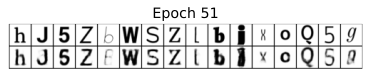

Epoch 051: train=136.575  (BCE=267.619 , KLD=18.455  ), val: 297.463 


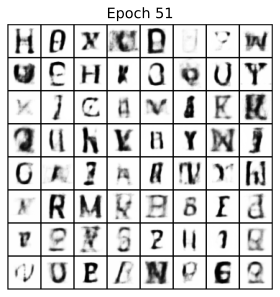

Epoch 052: train=136.324  (BCE=266.635 , KLD=18.543  ), val: 302.817 


Epoch 053: train=136.535  (BCE=266.817 , KLD=18.630  ), val: 296.892 


Epoch 054: train=136.425  (BCE=266.218 , KLD=18.711  ), val: 296.291 


Epoch 055: train=135.798  (BCE=264.953 , KLD=18.635  ), val: 297.537 


Epoch 056: train=135.457  (BCE=264.062 , KLD=18.645  ), val: 295.908 


Epoch 057: train=135.453  (BCE=263.804 , KLD=18.707  ), val: 297.674 


Epoch 058: train=135.406  (BCE=263.351 , KLD=18.791  ), val: 296.243 


Epoch 059: train=135.067  (BCE=262.464 , KLD=18.801  ), val: 297.012 


Epoch 060: train=134.535  (BCE=261.246 , KLD=18.773  ), val: 291.816 


Epoch 061: train=134.212  (BCE=259.984 , KLD=18.887  ), val: 296.605 


Epoch 062: train=134.250  (BCE=259.844 , KLD=18.945  ), val: 293.851 


Epoch 063: train=134.233  (BCE=259.732 , KLD=18.962  ), val: 294.076 


Epoch 064: train=133.390  (BCE=257.762 , KLD=18.929  ), val: 293.961 


Epoch 065: train=133.419  (BCE=257.515 , KLD=19.008  ), val: 292.226 


Epoch 066: train=133.070  (BCE=256.421 , KLD=19.064  ), val: 288.308 


Epoch 067: train=132.937  (BCE=256.331 , KLD=19.003  ), val: 292.004 


Epoch 068: train=132.681  (BCE=255.517 , KLD=19.046  ), val: 288.936 


Epoch 069: train=132.415  (BCE=254.675 , KLD=19.090  ), val: 290.807 


Epoch 070: train=132.108  (BCE=254.014 , KLD=19.064  ), val: 295.025 


Epoch 071: train=131.919  (BCE=253.408 , KLD=19.097  ), val: 291.216 


Epoch 072: train=131.593  (BCE=252.526 , KLD=19.114  ), val: 289.610 


Epoch 073: train=131.650  (BCE=252.275 , KLD=19.212  ), val: 286.921 


Epoch 074: train=131.399  (BCE=251.975 , KLD=19.131  ), val: 289.542 


Epoch 075: train=131.180  (BCE=251.226 , KLD=19.181  ), val: 285.158 


Epoch 076: train=131.352  (BCE=251.674 , KLD=19.177  ), val: 287.404 


Epoch 077: train=130.839  (BCE=250.017 , KLD=19.270  ), val: 287.382 


Epoch 078: train=130.788  (BCE=250.016 , KLD=19.238  ), val: 289.267 


Epoch 079: train=129.931  (BCE=247.683 , KLD=19.286  ), val: 284.772 


Epoch 080: train=129.853  (BCE=247.330 , KLD=19.326  ), val: 289.601 


Epoch 081: train=129.634  (BCE=247.090 , KLD=19.249  ), val: 288.621 


Epoch 082: train=130.135  (BCE=248.240 , KLD=19.274  ), val: 286.311 


Epoch 083: train=129.388  (BCE=246.049 , KLD=19.355  ), val: 286.382 


Epoch 084: train=128.899  (BCE=245.008 , KLD=19.310  ), val: 286.691 


Epoch 085: train=129.125  (BCE=245.313 , KLD=19.375  ), val: 288.565 


Epoch 086: train=129.247  (BCE=245.326 , KLD=19.448  ), val: 284.259 


Epoch 087: train=128.873  (BCE=244.361 , KLD=19.455  ), val: 283.467 


Epoch 088: train=128.428  (BCE=243.536 , KLD=19.383  ), val: 287.620 


Epoch 089: train=128.695  (BCE=243.983 , KLD=19.439  ), val: 286.135 


Epoch 090: train=128.361  (BCE=242.916 , KLD=19.496  ), val: 284.035 


Epoch 091: train=128.359  (BCE=243.299 , KLD=19.399  ), val: 288.148 


Epoch 092: train=128.730  (BCE=244.366 , KLD=19.365  ), val: 285.394 


Epoch 093: train=128.377  (BCE=243.347 , KLD=19.399  ), val: 285.964 


Epoch 094: train=127.801  (BCE=241.656 , KLD=19.461  ), val: 288.310 


Epoch 095: train=127.878  (BCE=241.527 , KLD=19.542  ), val: 283.251 


Epoch 096: train=127.533  (BCE=240.732 , KLD=19.525  ), val: 284.289 


Epoch 097: train=127.538  (BCE=240.571 , KLD=19.569  ), val: 286.589 


Epoch 098: train=127.187  (BCE=239.759 , KLD=19.552  ), val: 281.894 


Epoch 099: train=127.231  (BCE=239.982 , KLD=19.524  ), val: 285.124 


Epoch 100: train=127.434  (BCE=240.285 , KLD=19.575  ), val: 287.416 


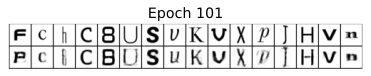

Epoch 101: train=127.184  (BCE=239.634 , KLD=19.581  ), val: 284.672 


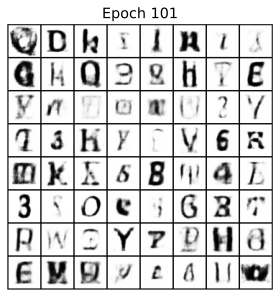

Epoch 102: train=127.633  (BCE=240.666 , KLD=19.604  ), val: 284.766 


Epoch 103: train=126.600  (BCE=238.244 , KLD=19.564  ), val: 284.094 


Epoch 104: train=126.679  (BCE=238.409 , KLD=19.572  ), val: 289.386 


Epoch 105: train=126.769  (BCE=238.763 , KLD=19.540  ), val: 283.471 


Epoch 106: train=126.481  (BCE=237.845 , KLD=19.590  ), val: 282.989 


Epoch 107: train=126.158  (BCE=237.175 , KLD=19.555  ), val: 282.568 


Epoch 108: train=125.625  (BCE=235.771 , KLD=19.573  ), val: 282.077 


Epoch 109: train=125.933  (BCE=236.013 , KLD=19.705  ), val: 281.245 


Epoch 110: train=125.908  (BCE=236.131 , KLD=19.660  ), val: 282.974 


Epoch 111: train=125.702  (BCE=235.482 , KLD=19.693  ), val: 281.691 


Epoch 112: train=125.471  (BCE=235.116 , KLD=19.641  ), val: 281.516 


Epoch 113: train=125.354  (BCE=234.628 , KLD=19.689  ), val: 281.222 


Epoch 114: train=125.381  (BCE=234.837 , KLD=19.654  ), val: 284.317 


Epoch 115: train=125.349  (BCE=234.638 , KLD=19.683  ), val: 286.975 


Epoch 116: train=124.733  (BCE=233.181 , KLD=19.663  ), val: 282.226 


Epoch 117: train=124.876  (BCE=233.311 , KLD=19.720  ), val: 280.821 


Epoch 118: train=125.138  (BCE=233.866 , KLD=19.745  ), val: 281.406 


Epoch 119: train=125.415  (BCE=234.280 , KLD=19.814  ), val: 282.843 


Epoch 120: train=124.702  (BCE=232.876 , KLD=19.720  ), val: 282.213 


Epoch 121: train=124.523  (BCE=232.694 , KLD=19.654  ), val: 284.088 


Epoch 122: train=124.832  (BCE=233.251 , KLD=19.707  ), val: 281.547 


Epoch 123: train=124.560  (BCE=232.366 , KLD=19.759  ), val: 285.412 


Epoch 124: train=124.478  (BCE=232.393 , KLD=19.700  ), val: 280.822 


Epoch 125: train=124.626  (BCE=232.429 , KLD=19.784  ), val: 282.820 


Epoch 126: train=124.104  (BCE=231.328 , KLD=19.733  ), val: 281.738 


Epoch 127: train=123.921  (BCE=230.999 , KLD=19.701  ), val: 280.309 


Epoch 128: train=124.041  (BCE=230.805 , KLD=19.824  ), val: 280.999 


Epoch 129: train=123.724  (BCE=230.232 , KLD=19.769  ), val: 281.258 


Epoch 130: train=123.814  (BCE=230.336 , KLD=19.800  ), val: 282.142 


Epoch 131: train=123.527  (BCE=229.405 , KLD=19.853  ), val: 280.026 


Epoch 132: train=124.140  (BCE=231.015 , KLD=19.834  ), val: 282.827 


Epoch 133: train=124.037  (BCE=230.800 , KLD=19.823  ), val: 280.620 


Epoch 134: train=123.544  (BCE=229.668 , KLD=19.798  ), val: 282.792 


Epoch 135: train=123.421  (BCE=229.550 , KLD=19.751  ), val: 283.415 


Epoch 136: train=123.558  (BCE=229.762 , KLD=19.783  ), val: 281.067 


Epoch 137: train=123.234  (BCE=228.736 , KLD=19.837  ), val: 281.648 


Epoch 138: train=123.057  (BCE=228.351 , KLD=19.823  ), val: 278.750 


Epoch 139: train=122.791  (BCE=227.741 , KLD=19.809  ), val: 283.842 


Epoch 140: train=123.392  (BCE=229.169 , KLD=19.828  ), val: 283.991 


Epoch 141: train=123.337  (BCE=228.898 , KLD=19.861  ), val: 284.731 


Epoch 142: train=123.153  (BCE=228.238 , KLD=19.911  ), val: 282.721 


Epoch 143: train=122.921  (BCE=228.011 , KLD=19.823  ), val: 283.512 


Epoch 144: train=123.128  (BCE=228.470 , KLD=19.838  ), val: 283.942 


Epoch 145: train=122.663  (BCE=227.381 , KLD=19.819  ), val: 280.158 


Epoch 146: train=122.735  (BCE=227.321 , KLD=19.879  ), val: 284.319 


Epoch 147: train=122.338  (BCE=226.252 , KLD=19.898  ), val: 279.466 


Epoch 148: train=122.857  (BCE=227.347 , KLD=19.948  ), val: 284.027 


Epoch 149: train=122.708  (BCE=226.923 , KLD=19.962  ), val: 282.658 


Epoch 150: train=122.638  (BCE=227.263 , KLD=19.833  ), val: 284.426 


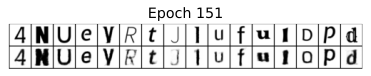

Epoch 151: train=122.485  (BCE=226.549 , KLD=19.916  ), val: 283.157 


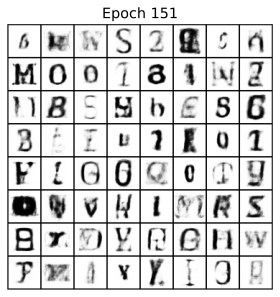

Epoch 152: train=121.982  (BCE=225.258 , KLD=19.924  ), val: 279.970 


Epoch 153: train=122.090  (BCE=225.611 , KLD=19.903  ), val: 279.675 


Epoch 154: train=122.276  (BCE=225.777 , KLD=19.979  ), val: 280.827 


Epoch 155: train=122.021  (BCE=225.348 , KLD=19.926  ), val: 280.062 


Epoch 156: train=121.733  (BCE=224.602 , KLD=19.933  ), val: 281.418 


Epoch 157: train=121.806  (BCE=224.676 , KLD=19.960  ), val: 278.230 


Epoch 158: train=122.258  (BCE=225.867 , KLD=19.944  ), val: 279.550 


Epoch 159: train=121.739  (BCE=224.441 , KLD=19.977  ), val: 285.087 


Epoch 160: train=121.524  (BCE=224.159 , KLD=19.913  ), val: 281.593 


Epoch 161: train=121.500  (BCE=223.933 , KLD=19.955  ), val: 284.317 


Epoch 162: train=121.800  (BCE=224.257 , KLD=20.060  ), val: 282.495 


Epoch 163: train=121.457  (BCE=223.692 , KLD=19.987  ), val: 281.150 


Epoch 164: train=121.431  (BCE=223.702 , KLD=19.969  ), val: 280.038 


Epoch 165: train=121.203  (BCE=223.213 , KLD=19.948  ), val: 278.587 


Epoch 166: train=121.543  (BCE=224.046 , KLD=19.953  ), val: 277.508 


Epoch 167: train=121.318  (BCE=223.374 , KLD=19.980  ), val: 279.936 


Epoch 168: train=121.364  (BCE=223.513 , KLD=19.974  ), val: 279.699 


Epoch 169: train=121.347  (BCE=223.449 , KLD=19.980  ), val: 280.547 


Epoch 170: train=120.887  (BCE=222.186 , KLD=20.008  ), val: 280.696 


Epoch 171: train=120.705  (BCE=222.012 , KLD=19.938  ), val: 282.147 


Epoch 172: train=121.045  (BCE=222.377 , KLD=20.059  ), val: 279.657 


Epoch 173: train=120.420  (BCE=221.424 , KLD=19.907  ), val: 280.746 


Epoch 174: train=120.467  (BCE=221.057 , KLD=20.028  ), val: 282.035 


Epoch 175: train=120.552  (BCE=221.246 , KLD=20.034  ), val: 280.901 


Epoch 176: train=120.788  (BCE=221.928 , KLD=20.011  ), val: 280.803 


Epoch 177: train=120.952  (BCE=222.228 , KLD=20.038  ), val: 282.436 


Epoch 178: train=120.778  (BCE=221.820 , KLD=20.031  ), val: 283.962 


Epoch 179: train=120.570  (BCE=221.679 , KLD=19.936  ), val: 286.054 


Epoch 180: train=120.453  (BCE=221.274 , KLD=19.965  ), val: 282.049 


Epoch 181: train=120.276  (BCE=220.654 , KLD=20.009  ), val: 282.493 


Epoch 182: train=120.341  (BCE=221.014 , KLD=19.960  ), val: 282.127 


Epoch 183: train=120.104  (BCE=220.006 , KLD=20.063  ), val: 280.876 


Epoch 184: train=120.235  (BCE=220.244 , KLD=20.086  ), val: 282.238 


Epoch 185: train=120.460  (BCE=220.727 , KLD=20.106  ), val: 284.555 


Epoch 186: train=120.744  (BCE=221.595 , KLD=20.066  ), val: 283.586 


Epoch 187: train=120.017  (BCE=220.015 , KLD=20.007  ), val: 280.985 


Epoch 188: train=119.998  (BCE=219.894 , KLD=20.026  ), val: 279.699 


Epoch 189: train=119.613  (BCE=218.808 , KLD=20.056  ), val: 281.590 


Epoch 190: train=119.871  (BCE=219.679 , KLD=19.999  ), val: 279.589 


Epoch 191: train=119.870  (BCE=219.386 , KLD=20.072  ), val: 282.599 


Epoch 192: train=119.910  (BCE=219.600 , KLD=20.044  ), val: 280.214 


Epoch 193: train=119.821  (BCE=218.944 , KLD=20.152  ), val: 281.667 


Epoch 194: train=119.835  (BCE=219.337 , KLD=20.062  ), val: 282.515 


Epoch 195: train=119.564  (BCE=218.494 , KLD=20.104  ), val: 279.503 


Epoch 196: train=119.528  (BCE=218.510 , KLD=20.077  ), val: 282.431 


Epoch 197: train=119.170  (BCE=217.286 , KLD=20.160  ), val: 279.439 


Epoch 198: train=119.417  (BCE=217.920 , KLD=20.155  ), val: 281.226 


Epoch 199: train=119.188  (BCE=217.819 , KLD=20.038  ), val: 279.453 


Epoch 200: train=119.576  (BCE=218.669 , KLD=20.068  ), val: 283.178 


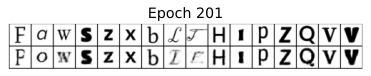

Epoch 201: train=119.633  (BCE=218.992 , KLD=20.022  ), val: 282.293 


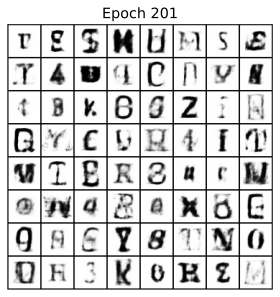

Epoch 202: train=119.332  (BCE=218.028 , KLD=20.075  ), val: 282.396 


Epoch 203: train=119.702  (BCE=218.948 , KLD=20.077  ), val: 279.270 


Epoch 204: train=119.572  (BCE=218.505 , KLD=20.106  ), val: 279.862 


Epoch 205: train=119.587  (BCE=218.510 , KLD=20.114  ), val: 282.970 


Epoch 206: train=119.017  (BCE=216.850 , KLD=20.173  ), val: 279.925 


Epoch 207: train=119.192  (BCE=217.369 , KLD=20.153  ), val: 280.883 


Epoch 208: train=119.286  (BCE=217.702 , KLD=20.128  ), val: 282.162 


Epoch 209: train=119.013  (BCE=217.377 , KLD=20.039  ), val: 283.473 


Epoch 210: train=118.929  (BCE=216.683 , KLD=20.160  ), val: 279.803 


Epoch 211: train=118.983  (BCE=217.235 , KLD=20.056  ), val: 278.406 


Epoch 212: train=119.379  (BCE=217.412 , KLD=20.259  ), val: 279.111 


Epoch 213: train=119.012  (BCE=216.899 , KLD=20.158  ), val: 278.554 


Epoch 214: train=118.756  (BCE=216.189 , KLD=20.176  ), val: 280.526 


Epoch 215: train=118.915  (BCE=216.457 , KLD=20.208  ), val: 280.716 


Epoch 216: train=118.234  (BCE=215.086 , KLD=20.125  ), val: 282.654 


Epoch 217: train=118.540  (BCE=215.797 , KLD=20.138  ), val: 281.271 


Epoch 218: train=118.819  (BCE=216.400 , KLD=20.162  ), val: 279.405 


Epoch 219: train=118.712  (BCE=216.090 , KLD=20.172  ), val: 279.961 


Epoch 220: train=118.449  (BCE=215.442 , KLD=20.170  ), val: 284.096 


Epoch 221: train=118.670  (BCE=215.677 , KLD=20.249  ), val: 279.995 


Epoch 222: train=118.390  (BCE=215.141 , KLD=20.209  ), val: 279.130 


Epoch 223: train=118.759  (BCE=216.058 , KLD=20.210  ), val: 282.749 


Epoch 224: train=118.579  (BCE=215.804 , KLD=20.161  ), val: 285.132 


Epoch 225: train=118.697  (BCE=216.027 , KLD=20.179  ), val: 281.333 


Epoch 226: train=118.464  (BCE=215.403 , KLD=20.189  ), val: 280.673 


Epoch 227: train=118.618  (BCE=215.835 , KLD=20.177  ), val: 279.280 


Epoch 228: train=118.627  (BCE=215.668 , KLD=20.225  ), val: 283.396 


Epoch 229: train=118.695  (BCE=215.997 , KLD=20.185  ), val: 283.379 


Epoch 230: train=118.749  (BCE=215.870 , KLD=20.251  ), val: 280.091 


Epoch 231: train=118.234  (BCE=214.993 , KLD=20.148  ), val: 278.882 


Epoch 232: train=118.042  (BCE=214.346 , KLD=20.190  ), val: 282.327 


Epoch 233: train=118.310  (BCE=215.077 , KLD=20.174  ), val: 280.913 


Epoch 234: train=118.268  (BCE=214.682 , KLD=20.247  ), val: 281.027 


Epoch 235: train=118.179  (BCE=214.484 , KLD=20.241  ), val: 282.881 


Epoch 236: train=117.786  (BCE=213.892 , KLD=20.144  ), val: 282.299 


Epoch 237: train=117.798  (BCE=213.618 , KLD=20.219  ), val: 283.006 


Epoch 238: train=117.998  (BCE=214.455 , KLD=20.135  ), val: 281.456 


Epoch 239: train=118.079  (BCE=214.607 , KLD=20.148  ), val: 283.055 


Epoch 240: train=117.946  (BCE=214.059 , KLD=20.202  ), val: 287.330 


Epoch 241: train=117.800  (BCE=213.696 , KLD=20.201  ), val: 280.349 


Epoch 242: train=117.765  (BCE=213.575 , KLD=20.209  ), val: 282.921 


Epoch 243: train=118.106  (BCE=214.751 , KLD=20.128  ), val: 280.977 


Epoch 244: train=118.004  (BCE=214.225 , KLD=20.196  ), val: 281.888 


Epoch 245: train=117.765  (BCE=213.639 , KLD=20.193  ), val: 283.544 


Epoch 246: train=117.660  (BCE=213.338 , KLD=20.203  ), val: 278.613 


Epoch 247: train=117.791  (BCE=213.420 , KLD=20.264  ), val: 281.199 


Epoch 248: train=117.198  (BCE=212.210 , KLD=20.196  ), val: 284.885 


Epoch 249: train=117.560  (BCE=213.155 , KLD=20.186  ), val: 279.125 


Epoch 250: train=117.856  (BCE=213.725 , KLD=20.229  ), val: 285.256 


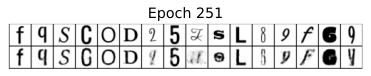

Epoch 251: train=117.444  (BCE=212.639 , KLD=20.243  ), val: 284.359 


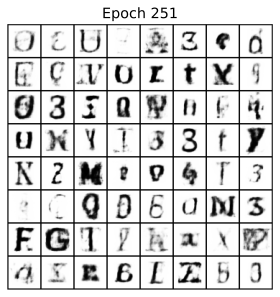

Epoch 252: train=117.117  (BCE=212.022 , KLD=20.193  ), val: 277.186 


Epoch 253: train=117.565  (BCE=212.783 , KLD=20.282  ), val: 284.251 


Epoch 254: train=117.414  (BCE=212.459 , KLD=20.269  ), val: 281.418 


Epoch 255: train=117.365  (BCE=212.407 , KLD=20.251  ), val: 281.007 


Epoch 256: train=117.151  (BCE=211.933 , KLD=20.236  ), val: 282.070 


Epoch 257: train=117.735  (BCE=213.188 , KLD=20.287  ), val: 280.271 


Epoch 258: train=117.555  (BCE=212.402 , KLD=20.371  ), val: 283.133 


Epoch 259: train=117.281  (BCE=212.234 , KLD=20.242  ), val: 280.516 


Epoch 260: train=117.523  (BCE=212.669 , KLD=20.285  ), val: 282.985 


Epoch 261: train=117.078  (BCE=211.646 , KLD=20.262  ), val: 285.282 


Epoch 262: train=117.323  (BCE=211.979 , KLD=20.332  ), val: 279.468 


Epoch 263: train=117.228  (BCE=212.185 , KLD=20.221  ), val: 281.929 


Epoch 264: train=117.178  (BCE=211.784 , KLD=20.290  ), val: 284.282 


Epoch 265: train=117.268  (BCE=212.020 , KLD=20.287  ), val: 279.981 


Epoch 266: train=117.422  (BCE=212.365 , KLD=20.297  ), val: 282.243 


Epoch 267: train=117.041  (BCE=211.405 , KLD=20.300  ), val: 283.450 


Epoch 268: train=117.355  (BCE=212.093 , KLD=20.324  ), val: 284.597 


Epoch 269: train=116.879  (BCE=211.067 , KLD=20.283  ), val: 285.450 


Epoch 270: train=117.185  (BCE=211.509 , KLD=20.364  ), val: 285.676 


Epoch 271: train=116.809  (BCE=210.768 , KLD=20.314  ), val: 280.388 


Epoch 272: train=116.911  (BCE=211.076 , KLD=20.300  ), val: 281.336 


Epoch 273: train=116.898  (BCE=210.958 , KLD=20.322  ), val: 282.503 


Epoch 274: train=116.996  (BCE=211.109 , KLD=20.346  ), val: 280.826 


Epoch 275: train=116.854  (BCE=210.672 , KLD=20.366  ), val: 280.525 


Epoch 276: train=116.404  (BCE=210.022 , KLD=20.247  ), val: 285.607 


Epoch 277: train=117.148  (BCE=211.185 , KLD=20.421  ), val: 285.874 


Epoch 278: train=117.092  (BCE=211.565 , KLD=20.291  ), val: 282.617 


Epoch 279: train=116.649  (BCE=210.356 , KLD=20.316  ), val: 286.263 


Epoch 280: train=116.855  (BCE=210.739 , KLD=20.349  ), val: 281.565 


Epoch 281: train=116.813  (BCE=210.602 , KLD=20.358  ), val: 283.280 


Epoch 282: train=116.623  (BCE=210.114 , KLD=20.361  ), val: 283.323 


Epoch 283: train=116.741  (BCE=210.483 , KLD=20.342  ), val: 286.865 


Epoch 284: train=116.774  (BCE=210.619 , KLD=20.329  ), val: 282.778 


Epoch 285: train=116.707  (BCE=210.340 , KLD=20.357  ), val: 281.676 


Epoch 286: train=116.660  (BCE=210.547 , KLD=20.276  ), val: 286.498 


Epoch 287: train=116.313  (BCE=209.627 , KLD=20.289  ), val: 282.778 


Epoch 288: train=116.739  (BCE=210.331 , KLD=20.379  ), val: 284.745 


Epoch 289: train=116.555  (BCE=210.080 , KLD=20.327  ), val: 282.972 


Epoch 290: train=116.967  (BCE=211.123 , KLD=20.324  ), val: 282.727 


Epoch 291: train=116.271  (BCE=209.477 , KLD=20.300  ), val: 286.339 


Epoch 292: train=116.816  (BCE=210.674 , KLD=20.342  ), val: 288.117 


Epoch 293: train=116.259  (BCE=209.259 , KLD=20.347  ), val: 283.165 


Epoch 294: train=116.629  (BCE=210.083 , KLD=20.373  ), val: 283.709 


Epoch 295: train=116.265  (BCE=209.234 , KLD=20.357  ), val: 283.063 


Epoch 296: train=116.210  (BCE=209.294 , KLD=20.308  ), val: 289.443 


Epoch 297: train=116.359  (BCE=209.822 , KLD=20.269  ), val: 283.724 


Epoch 298: train=116.000  (BCE=208.562 , KLD=20.360  ), val: 283.007 


Epoch 299: train=116.234  (BCE=209.057 , KLD=20.382  ), val: 283.005 


Epoch 300: train=116.117  (BCE=208.897 , KLD=20.349  ), val: 280.271 


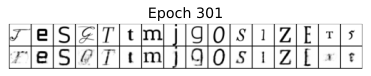

Epoch 301: train=116.450  (BCE=209.584 , KLD=20.385  ), val: 285.389 


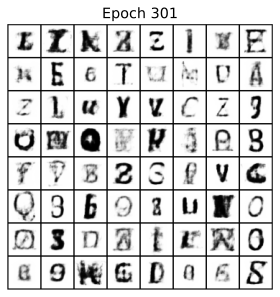

Epoch 302: train=116.073  (BCE=208.922 , KLD=20.315  ), val: 283.977 


Epoch 303: train=116.512  (BCE=210.043 , KLD=20.309  ), val: 283.731 


Epoch 304: train=116.166  (BCE=209.072 , KLD=20.336  ), val: 281.884 


Epoch 305: train=116.364  (BCE=209.534 , KLD=20.344  ), val: 283.580 


Epoch 306: train=116.047  (BCE=208.370 , KLD=20.437  ), val: 282.631 


Epoch 307: train=115.923  (BCE=208.300 , KLD=20.377  ), val: 280.011 


Epoch 308: train=116.197  (BCE=209.193 , KLD=20.325  ), val: 281.844 


Epoch 309: train=115.963  (BCE=208.168 , KLD=20.435  ), val: 283.058 


Epoch 310: train=115.974  (BCE=208.122 , KLD=20.454  ), val: 282.309 


Epoch 311: train=115.727  (BCE=208.027 , KLD=20.323  ), val: 283.438 


Epoch 312: train=116.310  (BCE=209.502 , KLD=20.319  ), val: 285.102 


Epoch 313: train=116.139  (BCE=208.466 , KLD=20.470  ), val: 281.732 


Epoch 314: train=116.237  (BCE=208.935 , KLD=20.415  ), val: 282.783 


Epoch 315: train=115.983  (BCE=208.187 , KLD=20.443  ), val: 280.915 


Epoch 316: train=116.053  (BCE=208.441 , KLD=20.423  ), val: 285.399 


Epoch 317: train=115.834  (BCE=208.006 , KLD=20.395  ), val: 286.840 


Epoch 318: train=115.756  (BCE=208.121 , KLD=20.317  ), val: 284.006 


Epoch 319: train=115.974  (BCE=208.074 , KLD=20.466  ), val: 282.299 


Epoch 320: train=115.544  (BCE=207.115 , KLD=20.436  ), val: 280.055 


Epoch 321: train=115.782  (BCE=207.928 , KLD=20.382  ), val: 286.635 


Epoch 322: train=115.670  (BCE=207.521 , KLD=20.413  ), val: 281.536 


Epoch 323: train=116.066  (BCE=208.160 , KLD=20.501  ), val: 284.197 


Epoch 324: train=115.779  (BCE=208.021 , KLD=20.357  ), val: 289.047 


Epoch 325: train=116.183  (BCE=208.547 , KLD=20.477  ), val: 283.648 


Epoch 326: train=116.127  (BCE=209.018 , KLD=20.325  ), val: 283.841 


Epoch 327: train=115.978  (BCE=208.290 , KLD=20.414  ), val: 284.187 


Epoch 328: train=115.711  (BCE=207.799 , KLD=20.370  ), val: 284.408 


Epoch 329: train=115.844  (BCE=207.817 , KLD=20.448  ), val: 285.995 


Epoch 330: train=115.706  (BCE=207.738 , KLD=20.382  ), val: 287.739 


Epoch 331: train=115.784  (BCE=207.873 , KLD=20.397  ), val: 288.050 


Epoch 332: train=115.621  (BCE=207.287 , KLD=20.441  ), val: 281.530 


Epoch 333: train=115.453  (BCE=206.880 , KLD=20.438  ), val: 287.077 


Epoch 334: train=115.513  (BCE=207.109 , KLD=20.418  ), val: 282.233 


Epoch 335: train=115.877  (BCE=207.561 , KLD=20.533  ), val: 287.854 


Epoch 336: train=114.920  (BCE=206.089 , KLD=20.303  ), val: 283.105 


Epoch 337: train=115.485  (BCE=207.189 , KLD=20.381  ), val: 283.876 


Epoch 338: train=115.165  (BCE=206.092 , KLD=20.455  ), val: 283.982 


Epoch 339: train=115.252  (BCE=206.031 , KLD=20.525  ), val: 283.838 


Epoch 340: train=115.533  (BCE=206.910 , KLD=20.480  ), val: 284.556 


Epoch 341: train=115.519  (BCE=207.063 , KLD=20.434  ), val: 282.970 


Epoch 342: train=115.499  (BCE=206.764 , KLD=20.496  ), val: 280.679 


Epoch 343: train=115.521  (BCE=207.154 , KLD=20.412  ), val: 285.821 


Epoch 344: train=115.518  (BCE=206.878 , KLD=20.479  ), val: 282.677 


Epoch 345: train=115.451  (BCE=206.809 , KLD=20.455  ), val: 283.538 


Epoch 346: train=115.277  (BCE=206.372 , KLD=20.455  ), val: 285.728 


Epoch 347: train=115.543  (BCE=207.072 , KLD=20.446  ), val: 285.305 


Epoch 348: train=115.658  (BCE=207.327 , KLD=20.455  ), val: 287.012 


Epoch 349: train=115.263  (BCE=206.129 , KLD=20.507  ), val: 285.253 


Epoch 350: train=115.287  (BCE=206.183 , KLD=20.509  ), val: 285.106 


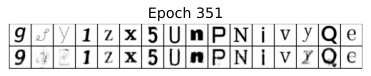

Epoch 351: train=115.264  (BCE=206.283 , KLD=20.469  ), val: 286.826 


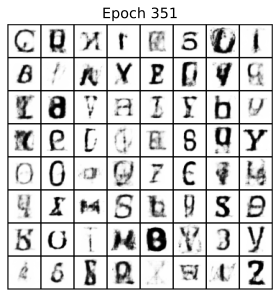

Epoch 352: train=115.114  (BCE=205.744 , KLD=20.510  ), val: 284.018 


Epoch 353: train=115.129  (BCE=206.107 , KLD=20.429  ), val: 284.768 


Epoch 354: train=115.286  (BCE=206.464 , KLD=20.438  ), val: 285.651 


Epoch 355: train=115.206  (BCE=205.978 , KLD=20.509  ), val: 287.056 


Epoch 356: train=115.358  (BCE=206.434 , KLD=20.490  ), val: 282.060 


Epoch 357: train=115.062  (BCE=205.650 , KLD=20.501  ), val: 283.717 


Epoch 358: train=115.176  (BCE=205.973 , KLD=20.492  ), val: 283.726 


Epoch 359: train=114.983  (BCE=205.766 , KLD=20.423  ), val: 284.711 


Epoch 360: train=115.294  (BCE=206.630 , KLD=20.401  ), val: 285.830 


Epoch 361: train=114.911  (BCE=205.613 , KLD=20.416  ), val: 286.796 


Epoch 362: train=115.184  (BCE=206.132 , KLD=20.457  ), val: 287.691 


Epoch 363: train=115.045  (BCE=205.964 , KLD=20.412  ), val: 283.363 


Epoch 364: train=115.002  (BCE=205.412 , KLD=20.524  ), val: 281.802 


Epoch 365: train=114.782  (BCE=204.960 , KLD=20.499  ), val: 288.827 


Epoch 366: train=115.403  (BCE=206.497 , KLD=20.503  ), val: 283.320 


Epoch 367: train=115.029  (BCE=205.668 , KLD=20.476  ), val: 283.380 


Epoch 368: train=115.353  (BCE=206.366 , KLD=20.505  ), val: 286.117 


Epoch 369: train=114.761  (BCE=205.333 , KLD=20.393  ), val: 284.040 


Epoch 370: train=114.840  (BCE=205.069 , KLD=20.508  ), val: 285.246 


Epoch 371: train=114.799  (BCE=205.496 , KLD=20.375  ), val: 282.824 


Epoch 372: train=115.253  (BCE=205.995 , KLD=20.534  ), val: 282.279 


Epoch 373: train=114.687  (BCE=204.709 , KLD=20.502  ), val: 286.767 


Epoch 374: train=114.724  (BCE=204.917 , KLD=20.473  ), val: 285.574 


Epoch 375: train=114.770  (BCE=205.035 , KLD=20.472  ), val: 287.031 


Epoch 376: train=114.427  (BCE=204.031 , KLD=20.509  ), val: 284.708 


Epoch 377: train=114.614  (BCE=204.604 , KLD=20.483  ), val: 285.373 


Epoch 378: train=115.251  (BCE=206.129 , KLD=20.500  ), val: 282.385 


Epoch 379: train=114.674  (BCE=204.527 , KLD=20.539  ), val: 285.312 


Epoch 380: train=114.778  (BCE=204.667 , KLD=20.570  ), val: 284.503 


Epoch 381: train=114.782  (BCE=205.067 , KLD=20.472  ), val: 285.242 


Epoch 382: train=114.493  (BCE=203.874 , KLD=20.590  ), val: 285.179 


Epoch 383: train=114.684  (BCE=204.373 , KLD=20.584  ), val: 284.630 


Epoch 384: train=115.061  (BCE=205.594 , KLD=20.515  ), val: 284.855 


Epoch 385: train=114.709  (BCE=204.545 , KLD=20.557  ), val: 284.620 


Epoch 386: train=114.645  (BCE=204.473 , KLD=20.535  ), val: 288.630 


Epoch 387: train=114.421  (BCE=204.111 , KLD=20.485  ), val: 285.750 


Epoch 388: train=115.089  (BCE=205.694 , KLD=20.507  ), val: 287.250 


Epoch 389: train=114.772  (BCE=204.675 , KLD=20.564  ), val: 286.088 


Epoch 390: train=114.669  (BCE=204.467 , KLD=20.551  ), val: 287.070 


Epoch 391: train=115.087  (BCE=205.337 , KLD=20.595  ), val: 288.023 


Epoch 392: train=114.978  (BCE=205.249 , KLD=20.549  ), val: 283.914 


Epoch 393: train=114.633  (BCE=204.325 , KLD=20.565  ), val: 284.438 


Epoch 394: train=114.471  (BCE=204.176 , KLD=20.500  ), val: 286.767 


Epoch 395: train=114.798  (BCE=204.576 , KLD=20.605  ), val: 281.609 


Epoch 396: train=114.379  (BCE=204.085 , KLD=20.465  ), val: 288.725 


Epoch 397: train=114.637  (BCE=204.713 , KLD=20.470  ), val: 283.223 


Epoch 398: train=114.424  (BCE=203.492 , KLD=20.642  ), val: 287.105 


Epoch 399: train=114.755  (BCE=204.815 , KLD=20.518  ), val: 279.664 


Epoch 400: train=114.516  (BCE=204.233 , KLD=20.514  ), val: 285.316 


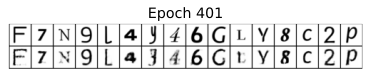

Epoch 401: train=114.421  (BCE=203.851 , KLD=20.551  ), val: 287.980 


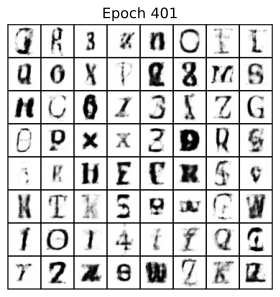

Epoch 402: train=114.749  (BCE=204.680 , KLD=20.548  ), val: 286.453 


Epoch 403: train=114.568  (BCE=203.998 , KLD=20.605  ), val: 285.860 


Epoch 404: train=114.780  (BCE=204.687 , KLD=20.566  ), val: 285.499 


Epoch 405: train=114.560  (BCE=204.162 , KLD=20.559  ), val: 283.199 


Epoch 406: train=114.461  (BCE=204.013 , KLD=20.535  ), val: 285.156 


Epoch 407: train=114.268  (BCE=203.487 , KLD=20.546  ), val: 284.270 


Epoch 408: train=114.459  (BCE=203.796 , KLD=20.588  ), val: 287.012 


Epoch 409: train=114.607  (BCE=204.446 , KLD=20.518  ), val: 286.377 


Epoch 410: train=114.123  (BCE=203.306 , KLD=20.501  ), val: 286.832 


Epoch 411: train=114.503  (BCE=204.001 , KLD=20.564  ), val: 283.033 


Epoch 412: train=114.145  (BCE=203.338 , KLD=20.506  ), val: 285.515 


Epoch 413: train=114.225  (BCE=203.324 , KLD=20.560  ), val: 283.444 


Epoch 414: train=114.324  (BCE=203.516 , KLD=20.573  ), val: 287.904 


Epoch 415: train=114.557  (BCE=204.107 , KLD=20.571  ), val: 283.652 


Epoch 416: train=114.215  (BCE=203.545 , KLD=20.498  ), val: 286.065 


Epoch 417: train=114.335  (BCE=203.555 , KLD=20.571  ), val: 289.081 


Epoch 418: train=114.390  (BCE=203.449 , KLD=20.632  ), val: 292.481 


Epoch 419: train=114.387  (BCE=204.009 , KLD=20.489  ), val: 291.232 


Epoch 420: train=114.553  (BCE=204.234 , KLD=20.537  ), val: 285.771 


Epoch 421: train=114.530  (BCE=204.050 , KLD=20.569  ), val: 284.431 


Epoch 422: train=114.380  (BCE=203.755 , KLD=20.549  ), val: 286.779 


Epoch 423: train=114.157  (BCE=203.181 , KLD=20.553  ), val: 290.132 


Epoch 424: train=114.528  (BCE=203.998 , KLD=20.580  ), val: 289.575 


Epoch 425: train=114.330  (BCE=203.611 , KLD=20.553  ), val: 288.742 


Epoch 426: train=114.093  (BCE=203.179 , KLD=20.514  ), val: 285.996 


Epoch 427: train=114.291  (BCE=203.369 , KLD=20.590  ), val: 286.687 


Epoch 428: train=114.087  (BCE=203.031 , KLD=20.547  ), val: 286.992 


Epoch 429: train=114.144  (BCE=203.054 , KLD=20.576  ), val: 285.361 


Epoch 430: train=113.849  (BCE=202.355 , KLD=20.567  ), val: 284.112 


Epoch 431: train=113.612  (BCE=201.936 , KLD=20.523  ), val: 284.669 


Epoch 432: train=114.166  (BCE=202.933 , KLD=20.620  ), val: 283.799 


Epoch 433: train=114.231  (BCE=203.139 , KLD=20.609  ), val: 285.451 


Epoch 434: train=114.380  (BCE=203.328 , KLD=20.656  ), val: 287.003 


Epoch 435: train=114.485  (BCE=203.666 , KLD=20.637  ), val: 286.347 


Epoch 436: train=114.509  (BCE=203.530 , KLD=20.686  ), val: 288.237 


Epoch 437: train=114.168  (BCE=203.198 , KLD=20.556  ), val: 287.605 


Epoch 438: train=113.932  (BCE=202.457 , KLD=20.593  ), val: 284.944 


Epoch 439: train=114.296  (BCE=203.401 , KLD=20.584  ), val: 290.161 


Epoch 440: train=114.155  (BCE=203.038 , KLD=20.587  ), val: 284.070 


Epoch 441: train=113.629  (BCE=201.771 , KLD=20.575  ), val: 287.621 


Epoch 442: train=113.749  (BCE=202.151 , KLD=20.555  ), val: 288.432 


Epoch 443: train=114.005  (BCE=202.706 , KLD=20.577  ), val: 285.356 


Epoch 444: train=114.102  (BCE=202.629 , KLD=20.657  ), val: 288.850 


Epoch 445: train=114.193  (BCE=203.258 , KLD=20.556  ), val: 286.182 


Epoch 446: train=114.017  (BCE=202.724 , KLD=20.579  ), val: 288.088 


Epoch 447: train=113.695  (BCE=202.030 , KLD=20.552  ), val: 286.575 


Epoch 448: train=113.789  (BCE=201.888 , KLD=20.646  ), val: 283.822 


Epoch 449: train=113.897  (BCE=202.345 , KLD=20.599  ), val: 287.450 


Epoch 450: train=113.930  (BCE=202.265 , KLD=20.640  ), val: 285.928 


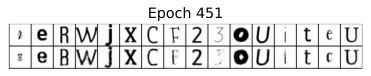

Epoch 451: train=113.911  (BCE=202.074 , KLD=20.676  ), val: 285.143 


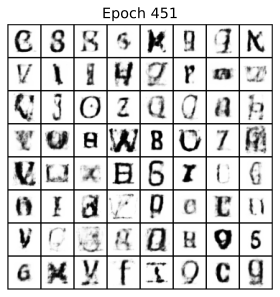

Epoch 452: train=113.740  (BCE=201.761 , KLD=20.647  ), val: 284.456 


Epoch 453: train=113.967  (BCE=202.574 , KLD=20.585  ), val: 285.761 


Epoch 454: train=113.880  (BCE=202.053 , KLD=20.662  ), val: 288.539 


Epoch 455: train=114.007  (BCE=202.793 , KLD=20.556  ), val: 287.904 


Epoch 456: train=113.760  (BCE=202.126 , KLD=20.569  ), val: 286.065 


Epoch 457: train=113.609  (BCE=201.587 , KLD=20.609  ), val: 287.053 


Epoch 458: train=114.003  (BCE=202.591 , KLD=20.604  ), val: 284.428 


Epoch 459: train=113.794  (BCE=201.805 , KLD=20.670  ), val: 287.379 


Epoch 460: train=113.365  (BCE=201.326 , KLD=20.522  ), val: 285.121 


Epoch 461: train=113.906  (BCE=202.458 , KLD=20.577  ), val: 287.302 


Epoch 462: train=113.794  (BCE=201.547 , KLD=20.735  ), val: 286.028 


Epoch 463: train=113.907  (BCE=202.232 , KLD=20.634  ), val: 290.061 


Epoch 464: train=114.180  (BCE=203.159 , KLD=20.573  ), val: 288.047 


Epoch 465: train=113.761  (BCE=201.677 , KLD=20.681  ), val: 289.407 


Epoch 466: train=114.330  (BCE=203.154 , KLD=20.668  ), val: 287.821 


Epoch 467: train=113.644  (BCE=201.467 , KLD=20.661  ), val: 288.730 


Epoch 468: train=113.596  (BCE=201.476 , KLD=20.628  ), val: 286.190 


Epoch 469: train=113.368  (BCE=201.118 , KLD=20.576  ), val: 287.983 


Epoch 470: train=113.406  (BCE=201.077 , KLD=20.609  ), val: 288.925 


Epoch 471: train=114.162  (BCE=202.900 , KLD=20.626  ), val: 294.486 


Epoch 472: train=113.847  (BCE=201.901 , KLD=20.679  ), val: 286.819 


Epoch 473: train=113.863  (BCE=202.216 , KLD=20.610  ), val: 284.916 


Epoch 474: train=113.120  (BCE=200.310 , KLD=20.622  ), val: 284.574 


Epoch 475: train=113.801  (BCE=201.861 , KLD=20.660  ), val: 286.350 


Epoch 476: train=114.030  (BCE=202.514 , KLD=20.640  ), val: 291.371 


Epoch 477: train=113.733  (BCE=201.661 , KLD=20.668  ), val: 288.177 


Epoch 478: train=113.855  (BCE=202.148 , KLD=20.622  ), val: 285.908 


Epoch 479: train=113.148  (BCE=200.531 , KLD=20.585  ), val: 284.959 


Epoch 480: train=113.496  (BCE=201.307 , KLD=20.608  ), val: 288.050 


Epoch 481: train=113.174  (BCE=200.575 , KLD=20.590  ), val: 286.291 


Epoch 482: train=113.641  (BCE=201.348 , KLD=20.689  ), val: 286.109 


Epoch 483: train=113.387  (BCE=201.172 , KLD=20.574  ), val: 286.049 


Epoch 484: train=113.555  (BCE=201.422 , KLD=20.617  ), val: 287.102 


Epoch 485: train=113.799  (BCE=201.940 , KLD=20.640  ), val: 289.552 


Epoch 486: train=113.609  (BCE=201.581 , KLD=20.611  ), val: 285.103 


Epoch 487: train=113.490  (BCE=201.347 , KLD=20.594  ), val: 287.074 


Epoch 488: train=113.336  (BCE=200.599 , KLD=20.685  ), val: 288.802 


Epoch 489: train=113.564  (BCE=201.484 , KLD=20.606  ), val: 284.498 


Epoch 490: train=113.169  (BCE=200.324 , KLD=20.650  ), val: 286.950 


Epoch 491: train=113.757  (BCE=201.626 , KLD=20.691  ), val: 285.850 


Epoch 492: train=113.302  (BCE=200.675 , KLD=20.645  ), val: 287.784 


Epoch 493: train=112.943  (BCE=200.141 , KLD=20.554  ), val: 288.481 


Epoch 494: train=113.505  (BCE=200.935 , KLD=20.707  ), val: 286.474 


Epoch 495: train=113.615  (BCE=201.535 , KLD=20.626  ), val: 288.743 


Epoch 496: train=113.493  (BCE=201.139 , KLD=20.648  ), val: 288.398 


Epoch 497: train=113.496  (BCE=201.020 , KLD=20.680  ), val: 286.448 


Epoch 498: train=113.276  (BCE=200.618 , KLD=20.643  ), val: 286.348 


Epoch 499: train=113.629  (BCE=201.594 , KLD=20.620  ), val: 285.939 


Epoch 500: train=113.175  (BCE=200.707 , KLD=20.558  ), val: 287.638 


In [22]:
model_name = f'vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
options = {
    'model_name': model_name,
    'input_dim': (50, 50),
    'z': 32,
    'hidden_dim': 1000,
    'n_hidden_encoder': 2,
    'n_hidden_decoder': 1,
    'lr': 1e-3,
    'beta': 0.80,
    'epochs': 500,
    'batch_size': 64
}

make_run(options)

### Qualidade das Amostras Geradas

**Etapas**

11. Avaliação das imagens geradas por um modelo:
    * **Inception Score**: Medida da qualidade e diversidade das imagens geradas.
    * **Fréchet Inception Distance**: Medida da distância entre as distribuições das imagens geradas e reais.

In [44]:
device2, model2, _, _ = initialize_test_run(options)

model2.load_state_dict(
    torch.load('./_models/vae_20240927-152911_201.model',
               map_location=torch.device('cpu')))

# sample_latent_space('a')

Device:  cuda


/tmp/ipykernel_56127/3475926262.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('./_models/vae_20240927-152911_201.model',


<All keys matched successfully>

torch.Size([64, 1, 50, 50])


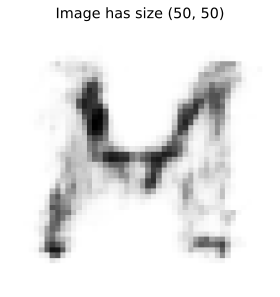

In [69]:
def get_samples(model, device, latent_dim=32, n_samples=64):
    with torch.no_grad():
        sample=torch.randn(n_samples,latent_dim).to(device)
        return model.decode(sample).cpu().view(n_samples, 1, 50, 50)

samples = get_samples(model2, device2)
print(samples.shape)
show_img(samples[0])

In [70]:
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

/home/tiago/dev/generative_networks/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tiago/dev/generative_networks/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:48<00:00, 2.23MB/s] 


Inception Score: 1.0384108749522478 ± 0.009314233444647992


https://pytorch.org/ignite/generated/ignite.metrics.FID.html#ignite.metrics.FID

In [72]:
def inception_score(images, splits=10):
    N = len(images)
    assert N > 0
    assert isinstance(images, torch.Tensor)

    # Load pre-trained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()

    # Resize images to 299x299 as required by InceptionV3
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # Get predictions
    preds = []
    for i in range(0, N, 32):
        batch = images[i:i+32]
        with torch.no_grad():
            pred = inception_model(batch)
            preds.append(F.softmax(pred, dim=1).cpu().numpy())
    preds = np.concatenate(preds, axis=0)

    # Compute the Inception Score
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Example usage
images = torch.rand(64, 1, 50, 50)  # Random images for demonstration
mean_is, std_is = inception_score(images)
print(f'Inception Score: {mean_is} ± {std_is}')

mean_is, std_is = inception_score(samples)
print(f'Inception Score: {mean_is} ± {std_is}')

/home/tiago/dev/generative_networks/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tiago/dev/generative_networks/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 299, 299] to have 3 channels, but got 1 channels instead